# SVR Forecasting

# 1. Setup

In [115]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sklearn.preprocessing import StandardScaler
from matplotlib import figure as figure
from statsmodels.tools.eval_measures import mse, rmse, meanabs
import datetime

In [134]:
file_path= "/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Data/main_new.xlsx"
main = pd.read_excel(file_path)
main = main.set_index(main['time'])
main = main.drop(['Unnamed: 0', 'time'], axis=1) #remove unnecessary index column
main

Spot Close   Spot Volume  CQF Close   CQF Volume  \
time                                                                    
2019-07-21 13:00:00     10542.0  1.052900e+00   10656.50       0.0000   
2019-07-21 13:15:00     10584.0  0.000000e+00   10701.50       0.0000   
2019-07-21 13:30:00     10568.0  0.000000e+00   10686.00       0.0000   
2019-07-21 13:45:00     10535.5  0.000000e+00   10648.00       0.0000   
2019-07-21 14:00:00     10531.0  0.000000e+00   10637.25       0.0000   
...                         ...           ...        ...          ...   
2022-04-30 21:00:00     38278.0  6.148997e+06   38380.00  479102.9521   
2022-04-30 21:15:00     38325.0  4.012060e+06   38431.00   94022.4783   
2022-04-30 21:30:00     38355.0  3.339375e+06   38460.00   41562.1715   
2022-04-30 21:45:00     38304.0  1.276453e+06   38416.00   45640.5218   
2022-04-30 22:00:00     38239.0  4.431048e+06   38353.00  206411.5591   

                     NQF Close   NQF Volume      diff  
time                                                   
2019-07-21 13:00:00        0.0       0.0000 -10656.50  
2019-07-21 13:15:00        0.0       0.0000 -10701.50  
2019-07-21 13:30:00        0.0       0.0000 -10686.00  
2019-07-21 13:45:00        0.0       0.0000 -10648.00  
2019-07-21 14:00:00        0.0       0.0000 -10637.25  
...                        ...          ...       ...  
2022-04-30 21:00:00    38690.0  121668.0480    310.00  
2022-04-30 21:15:00    38753.0    5289.7845    322.00  
2022-04-30 21:30:00    38779.0     976.3274    319.00  
2022-04-30 21:45:00    38737.0    1945.0568    321.00  
2022-04-30 22:00:00    38654.0    3701.9621    301.00  

[97364 rows x 7 columns]

# 2. Preparation

In [135]:
# Both volume columns have zero values. So we need the minimum non-zero values. 
non_zero_cqf_vol = []
for i in range(0, len(main['CQF Volume'])):
    if main['CQF Volume'][i] != 0:
        non_zero_cqf_vol.append(main['CQF Volume'][i])

non_zero_spot_vol = []
for i in range(0, len(main['Spot Volume'])):
    if main['Spot Volume'][i] != 0:
        non_zero_spot_vol.append(main['Spot Volume'][i])

non_zero_nqf_vol = []
for i in range(0, len(main['NQF Volume'])):
    if main['NQF Volume'][i] != 0:
        non_zero_nqf_vol.append(main['NQF Volume'][i])

min(non_zero_cqf_vol), min(non_zero_spot_vol), min(non_zero_nqf_vol)

(0.6133, 0.7171, 0.6171)

In [136]:
main = main[datetime.datetime(2021, 6, 30, 0, 0):datetime.datetime(2022, 1, 1, 0, 0)].copy()

# Define the log current quarter future price
main['log_price'] = np.log(main['CQF Close'])
# Define the log returns for the current quarter future price
main['returns'] = np.log(main['CQF Close']).diff()
# Define the lagged log returns for the current quarter future price
main['lag_returns_1'] = main['returns'].shift(1)
main['lag_returns_2'] = main['returns'].shift(2)
main['lag_returns_3'] = main['returns'].shift(3)
main['lag_returns_4'] = main['returns'].shift(4)

# Define the log volume for the current quarter future
main['cqf_log_vol'] = np.log(main['CQF Volume'] + min(non_zero_cqf_vol))
# Define the change in volume for the current quarter future
main['change_cqf_vol'] = main['cqf_log_vol'].diff()
# Define the lagged change in log volume for the current quarter future
main['lag_change_cqf_vol'] = main['change_cqf_vol'].shift(1)

# Define the log next quarter future price
main['log_nqf_price'] = np.log(main['NQF Close'])
# Define the log returns for the next quarter future price
main['nqf_returns'] = np.log(main['NQF Close']).diff()
# Define the lagged log returns for the next quarter future price
main['lag_nqf_returns'] = main['nqf_returns'].shift(1)

# Define the log volume for the next quarter future
main['nqf_log_vol'] = np.log(main['NQF Volume'] + min(non_zero_nqf_vol))
# Define the change in volume for the next quarter future
main['change_nqf_vol'] = main['nqf_log_vol'].diff()
# Define the lagged change in log volume for the next quarter future
main['lag_change_nqf_vol'] = main['change_nqf_vol'].shift(1)

# Define the log current quarter future price
main['log_spot_price'] = np.log(main['Spot Close'])
# Define the log returns for the current quarter future price
main['spot_returns'] = np.log(main['Spot Close']).diff()
# Define the lagged log returns for the current quarter future price
main['lag_spot_returns'] = main['spot_returns'].shift(1)

# Define the log volume for the spot
main['spot_log_vol'] = np.log(main['Spot Volume'] + min(non_zero_spot_vol))
# Define the change in volume for the spot
main['change_spot_vol'] = main['spot_log_vol'].diff()
# Define the lagged change in log volume for the spot
main['lag_change_spot_vol'] = main['change_spot_vol'].shift(1)

main = main[datetime.datetime(2021, 7, 1, 0, 0):datetime.datetime(2022, 1, 1, 0, 0)]
main = main.reset_index()
main.loc[:, 'log_price':'lag_change_spot_vol']

log_price   returns  lag_returns_1  lag_returns_2  lag_returns_3  \
0      10.475709 -0.006552      -0.001540       0.002831      -0.002915   
1      10.475060 -0.000649      -0.006552      -0.001540       0.002831   
2      10.473308 -0.001752      -0.000649      -0.006552      -0.001540   
3      10.472573 -0.000736      -0.001752      -0.000649      -0.006552   
4      10.475060  0.002487      -0.000736      -0.001752      -0.000649   
...          ...       ...            ...            ...            ...   
17660  10.765702  0.002515       0.000127      -0.002410      -0.000908   
17661  10.764223 -0.001479       0.002515       0.000127      -0.002410   
17662  10.766420  0.002196      -0.001479       0.002515       0.000127   
17663  10.761238 -0.005182       0.002196      -0.001479       0.002515   
17664  10.764033  0.002795      -0.005182       0.002196      -0.001479   

       lag_returns_4  cqf_log_vol  change_cqf_vol  lag_change_cqf_vol  \
0           0.004937    14.011006        0.314069           -0.339966   
1          -0.002915    14.158475        0.147468            0.314069   
2           0.002831    13.512547       -0.645927            0.147468   
3          -0.001540    12.959508       -0.553039           -0.645927   
4          -0.006552    13.002368        0.042859           -0.553039   
...              ...          ...             ...                 ...   
17660       0.002556    14.276949       -0.094522            1.363460   
17661      -0.000908    13.692055       -0.584894           -0.094522   
17662      -0.002410    14.345756        0.653702           -0.584894   
17663       0.000127    13.747210       -0.598546            0.653702   
17664       0.002515    13.545086       -0.202124           -0.598546   

       log_nqf_price  ...  lag_nqf_returns  nqf_log_vol  change_nqf_vol  \
0          10.494934  ...        -0.001512    12.337220        0.696390   
1          10.493882  ...        -0.005878    14.085526        1.748306   
2          10.492274  ...        -0.001052    10.474126       -3.611401   
3          10.491552  ...        -0.001608     9.839254       -0.634872   
4          10.493771  ...        -0.000722    10.732060        0.892806   
...              ...  ...              ...          ...             ...   
17660      10.791873  ...         0.000804    12.816224       -1.203518   
17661      10.789979  ...         0.002079    12.897579        0.081355   
17662      10.793824  ...        -0.001894    14.118414        1.220835   
17663      10.788143  ...         0.003846    13.321494       -0.796920   
17664      10.790329  ...        -0.005681    13.504216        0.182722   

       lag_change_nqf_vol  log_spot_price  spot_returns  lag_spot_returns  \
0                0.443352       10.458493     -0.006209         -0.001397   
1                0.696390       10.457344     -0.001149         -0.006209   
2                1.748306       10.456510     -0.000834         -0.001149   
3               -3.611401       10.455561     -0.000950         -0.000834   
4               -0.634872       10.457890      0.002329         -0.000950   
...                   ...             ...           ...               ...   
17660            0.269117       10.745658      0.002480          0.000475   
17661           -1.203518       10.744171     -0.001487          0.002480   
17662            0.081355       10.746390      0.002219         -0.001487   
17663            1.220835       10.740713     -0.005677          0.002219   
17664           -0.796920       10.743394      0.002680         -0.005677   

       spot_log_vol  change_spot_vol  lag_change_spot_vol  
0         15.464072         0.220842            -0.139949  
1         15.168848        -0.295224             0.220842  
2         14.399752        -0.769095            -0.295224  
3         14.288884        -0.110868            -0.769095  
4         14.493233         0.204349            -0.110868  
...             ...              ...       

# 3. Linear Models

# Linear Pure AR - Model Specification (85:15)

In [270]:
# create training sample data set
train_size = int(0.85 * len(main))
train = main[:train_size]
test = main[train_size:]

X = list()
for lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 in zip(train['lag_returns_1'], train['lag_returns_2'], train['lag_returns_3'], train['lag_returns_4']):
    X.append( [ lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 ] )

In [176]:
parameters = {
    'C' : [ 1, 10, 100, 1000 ], 
    'kernel' : [ 'linear' ], 
    'epsilon' : [ 0.01, 0.001, 0.0001, 0.00001 ] 
}
tscv = TimeSeriesSplit(n_splits=5)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [157]:
lin_svr = GridSearchCV(
    estimator = SVR(), 
    param_grid = parameters,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1,
    verbose = 2
)
lin_svr.fit(X, train['returns'])
lin_svr.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'C': 100, 'epsilon': 0.0001, 'kernel': 'linear'}

[CV] END ..................C=1, epsilon=0.001, kernel=linear; total time=   3.6s
[CV] END ..................C=1, epsilon=1e-05, kernel=linear; total time=   8.9s
[CV] END .................C=10, epsilon=1e-05, kernel=linear; total time=   0.8s
[CV] END .................C=10, epsilon=1e-05, kernel=linear; total time=   2.8s
[CV] END .................C=100, epsilon=0.01, kernel=linear; total time=   0.1s
[CV] END .................C=100, epsilon=0.01, kernel=linear; total time=   0.1s
[CV] END .................C=100, epsilon=0.01, kernel=linear; total time=   0.2s
[CV] END .................C=100, epsilon=0.01, kernel=linear; total time=   0.5s
[CV] END .................C=100, epsilon=0.01, kernel=linear; total time=   0.6s
[CV] END ................C=100, epsilon=0.001, kernel=linear; total time=   0.8s
[CV] END ................C=100, epsilon=0.001, kernel=linear; total time=   5.7s
[CV] END ...............C=100, epsilon=0.0001, kernel=linear; total time=  12.9s
[CV] END ..............C=100

In [164]:
C_lin = lin_svr.best_params_['C']
epsilon_lin = lin_svr.best_params_['epsilon']
lin_svr.best_score_

-0.003802494631542539

In [271]:
lin_svr_model = SVR(
    kernel = 'linear', 
    C = C_lin, 
    epsilon = epsilon_lin
)
lin_svr_model.fit(X, train['returns'])

SVR(C=100, epsilon=0.0001, kernel='linear')

In [272]:
Xtest = list()
for lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 in zip(test['lag_returns_1'], test['lag_returns_2'], test['lag_returns_3'], test['lag_returns_4']):
    Xtest.append( [ lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 ] )
    
lin_pred = lin_svr_model.predict(Xtest)

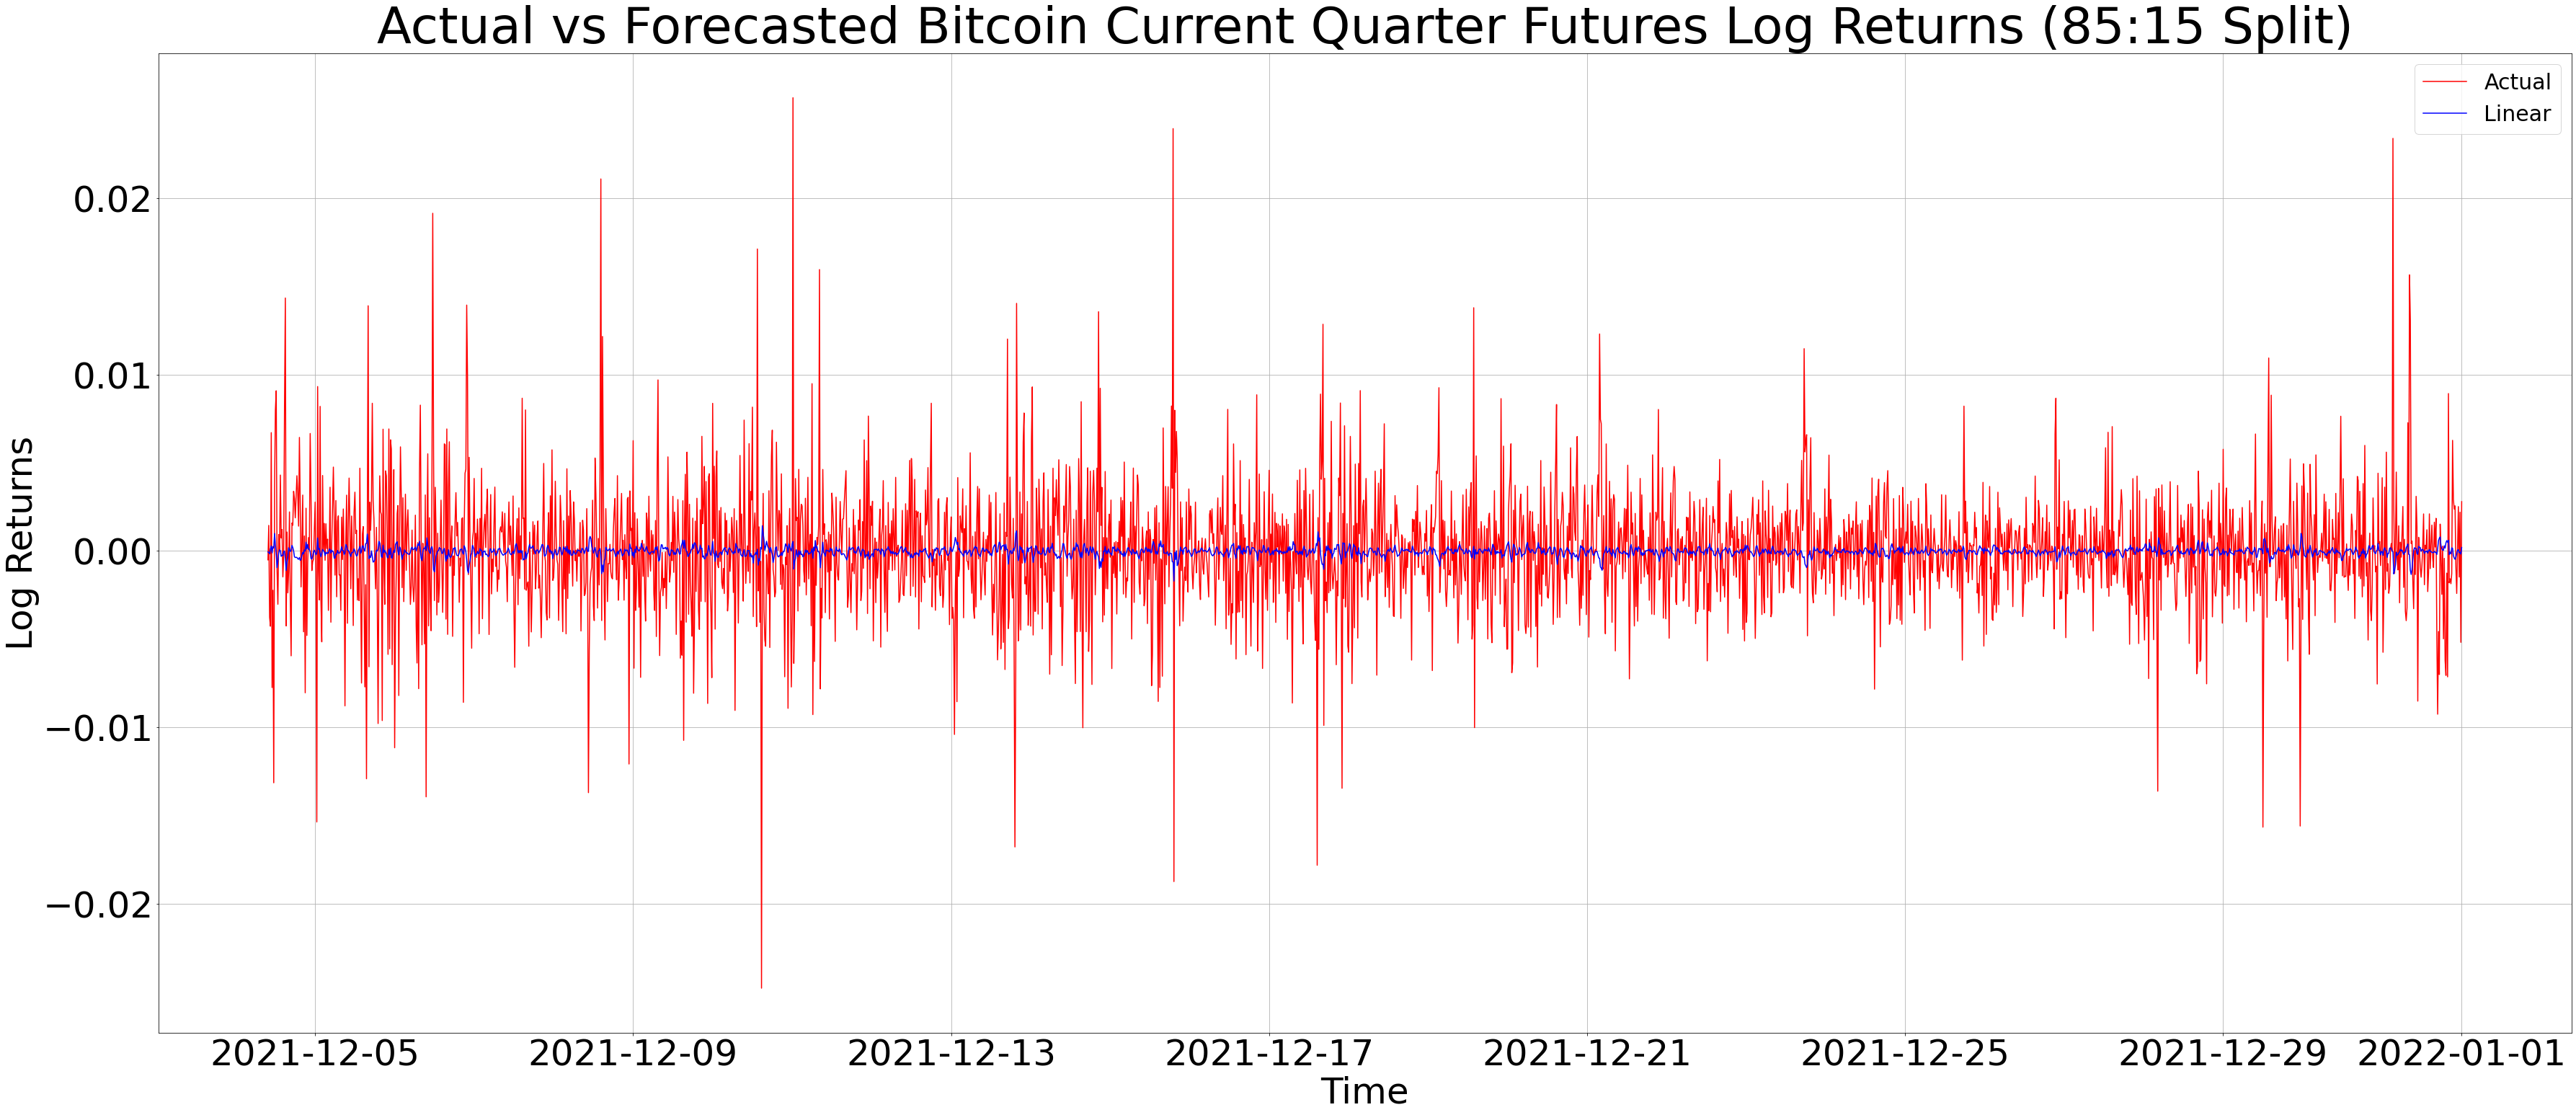

In [275]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (60,25)

ax.plot(test['time'], test['returns'], color='red', label = 'Actual')
ax.plot(test['time'], lin_pred, color='blue', label = 'Linear')

plt.legend(loc="upper right", prop={'size': 30})
plt.grid(True)
ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (85:15 Split)', fontsize=70)

plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/SVR_lin_uni_85.pdf')
plt.show()

In [181]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

lin_mse = round(mse(np.array(test['returns']), lin_pred), ndigits=10)
lin_rmse = round(rmse(np.array(test['returns']), lin_pred), ndigits=10)
lin_mae = round(meanabs(np.array(test['returns']), lin_pred), ndigits=10)

print("Linear MSE:   ", lin_mse)
print("Linear RMSE:  ", lin_rmse)
print("Linear MAE:   ", lin_mae)

Linear MSE:    1.2402e-05
Linear RMSE:   0.0035216501
Linear MAE:    0.0024808096


# Linear Pure AR - (75:25)

In [182]:
# create training sample data set
train_size = int(0.75 * len(main))
train = main[:train_size]
test = main[train_size:]

X = list()
for lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 in zip(train['lag_returns_1'], train['lag_returns_2'], train['lag_returns_3'], train['lag_returns_4']):
    X.append( [ lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 ] )

In [183]:
lin_svr_model = SVR(
    kernel = 'linear', 
    C = C_lin, 
    epsilon = epsilon_lin
)
lin_svr_model.fit(X, train['returns'])

SVR(C=100, epsilon=0.0001, kernel='linear')

In [184]:
Xtest = list()
for lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 in zip(test['lag_returns_1'], test['lag_returns_2'], test['lag_returns_3'], test['lag_returns_4']):
    Xtest.append( [ lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 ] )
    
lin_pred = lin_svr_model.predict(Xtest)

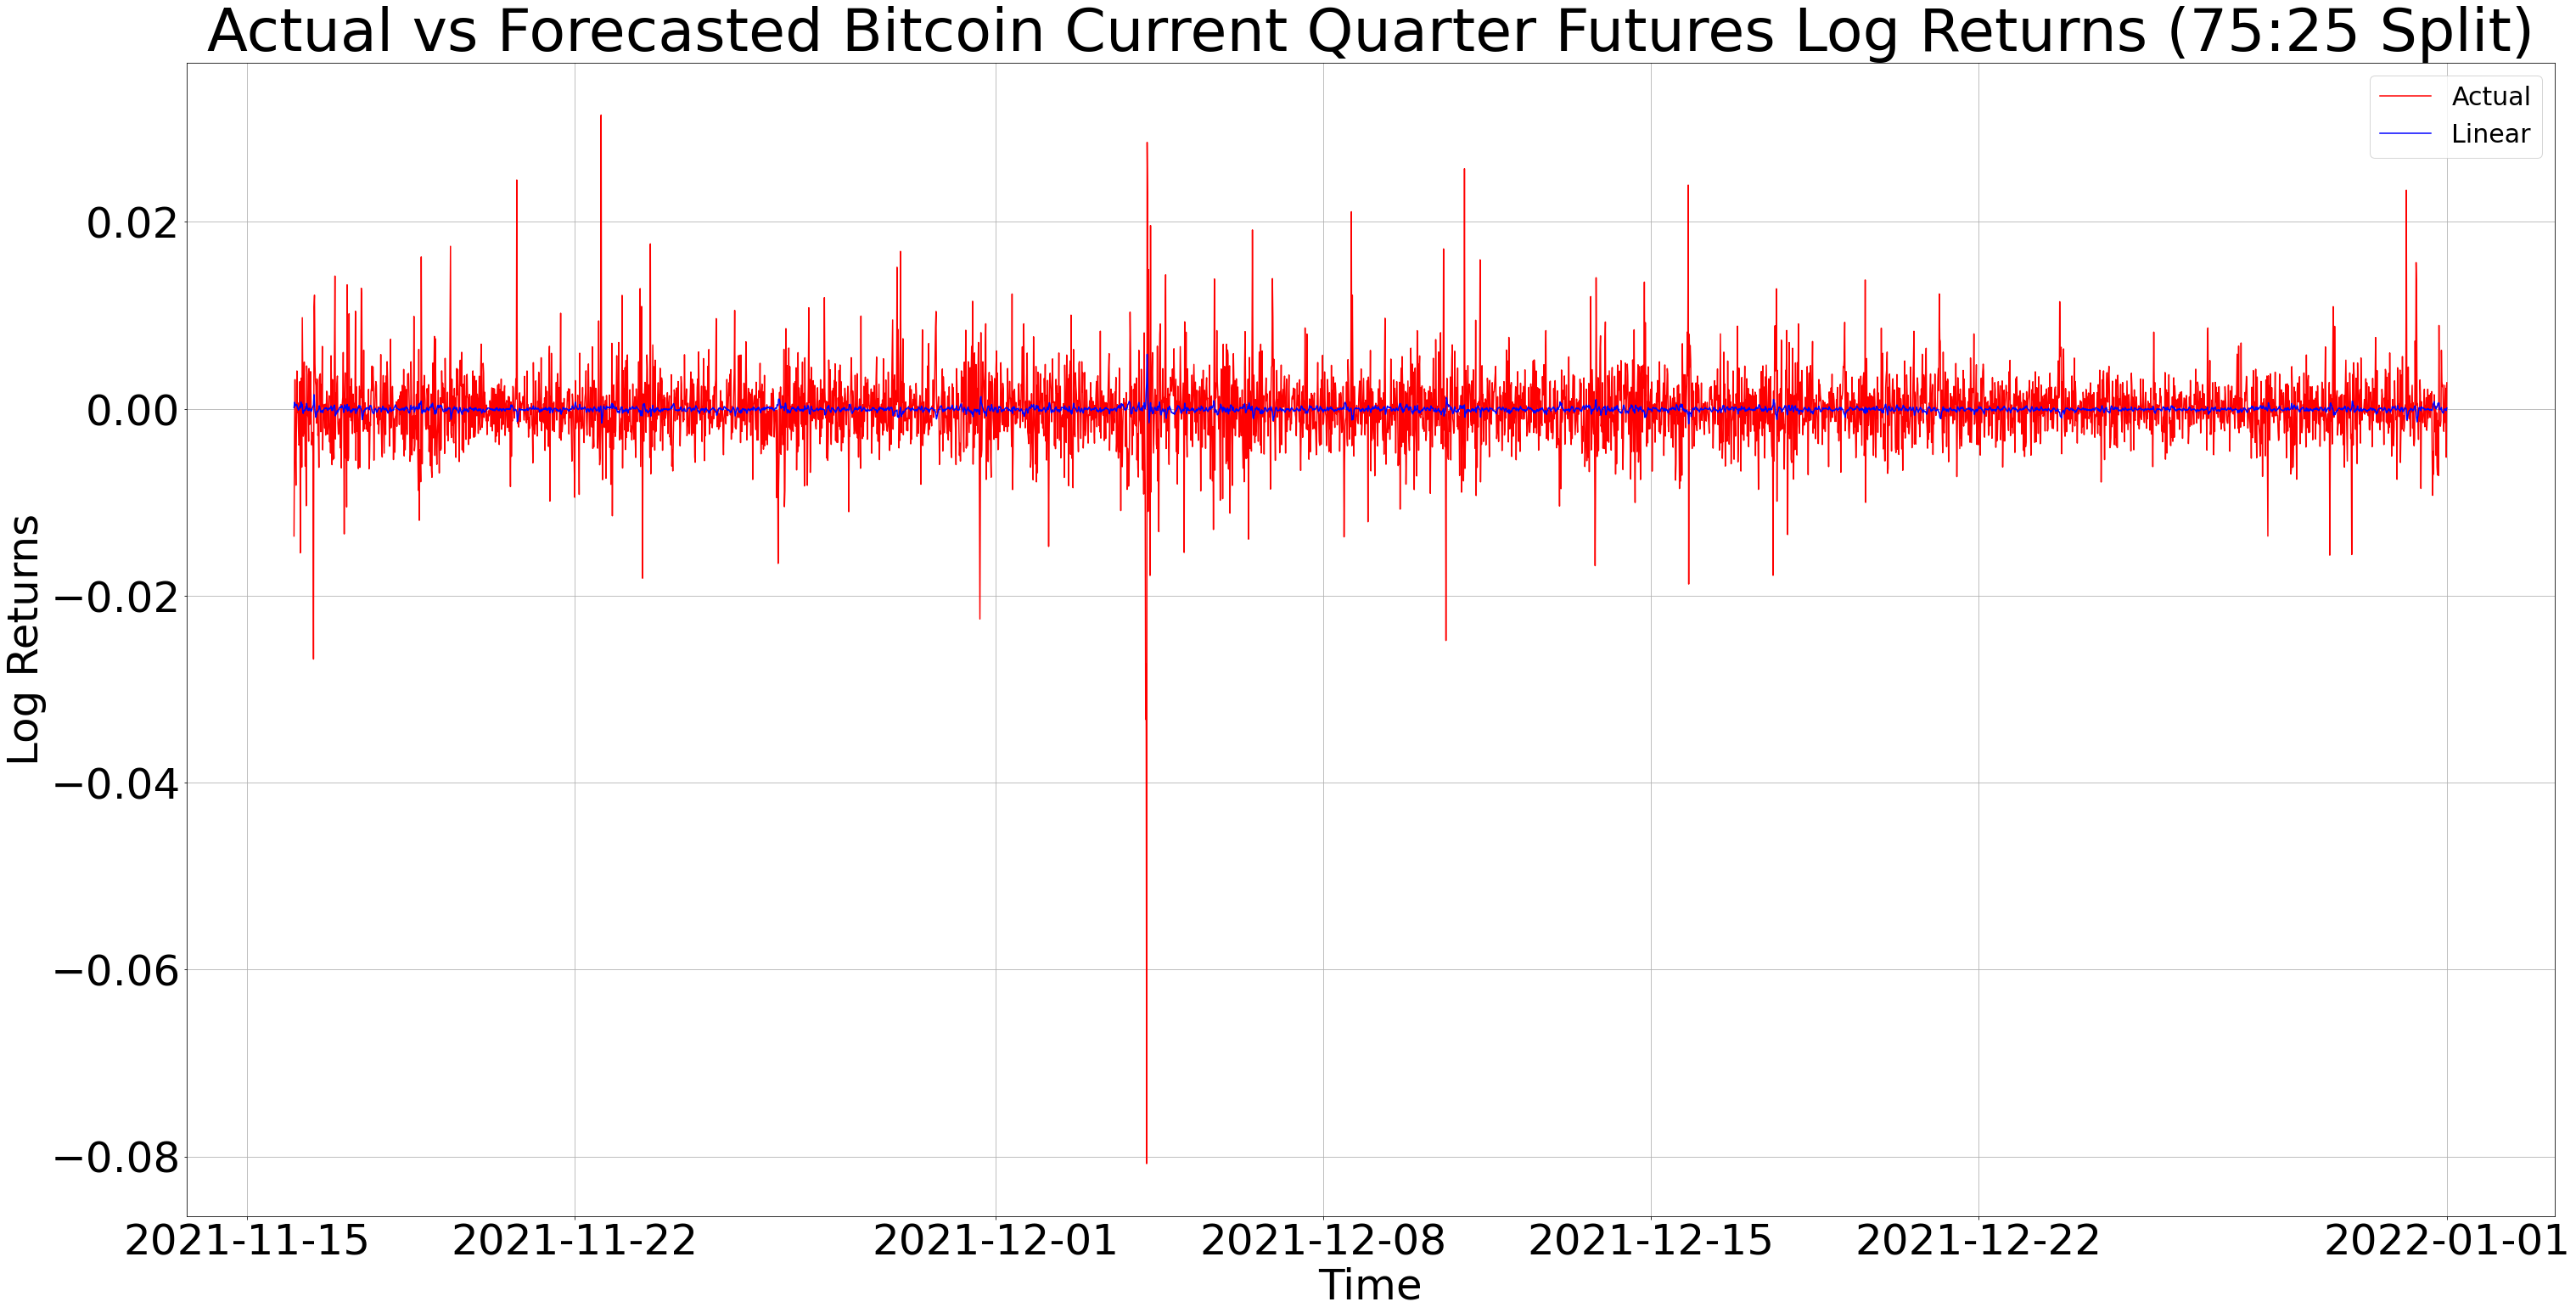

In [186]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (50,25)

ax.plot(test['time'], test['returns'], color='red', label = 'Actual')
ax.plot(test['time'], lin_pred, color='blue', label = 'Linear')

plt.legend(loc="upper right", prop={'size': 30})
plt.grid(True)
ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (75:25 Split)', fontsize=70)

plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/SVR_lin_uni_75.pdf')
plt.show()

In [187]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

lin_mse = round(mse(np.array(test['returns']), lin_pred), ndigits=10)
lin_rmse = round(rmse(np.array(test['returns']), lin_pred), ndigits=10)
lin_mae = round(meanabs(np.array(test['returns']), lin_pred), ndigits=10)

print("Linear MSE:   ", lin_mse)
print("Linear RMSE:  ", lin_rmse)
print("Linear MAE:   ", lin_mae)

Linear MSE:    1.58246e-05
Linear RMSE:   0.0039780165
Linear MAE:    0.0026341139


# Linear Pure AR - (95:5)

In [188]:
# create training sample data set
train_size = int(0.95 * len(main))
train = main[:train_size]
test = main[train_size:]

X = list()
for lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 in zip(train['lag_returns_1'], train['lag_returns_2'], train['lag_returns_3'], train['lag_returns_4']):
    X.append( [ lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 ] )

In [189]:
lin_svr_model = SVR(
    kernel = 'linear', 
    C = C_lin, 
    epsilon = epsilon_lin
)
lin_svr_model.fit(X, train['returns'])

SVR(C=100, epsilon=0.0001, kernel='linear')

In [190]:
Xtest = list()
for lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 in zip(test['lag_returns_1'], test['lag_returns_2'], test['lag_returns_3'], test['lag_returns_4']):
    Xtest.append( [ lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 ] )
    
lin_pred = lin_svr_model.predict(Xtest)

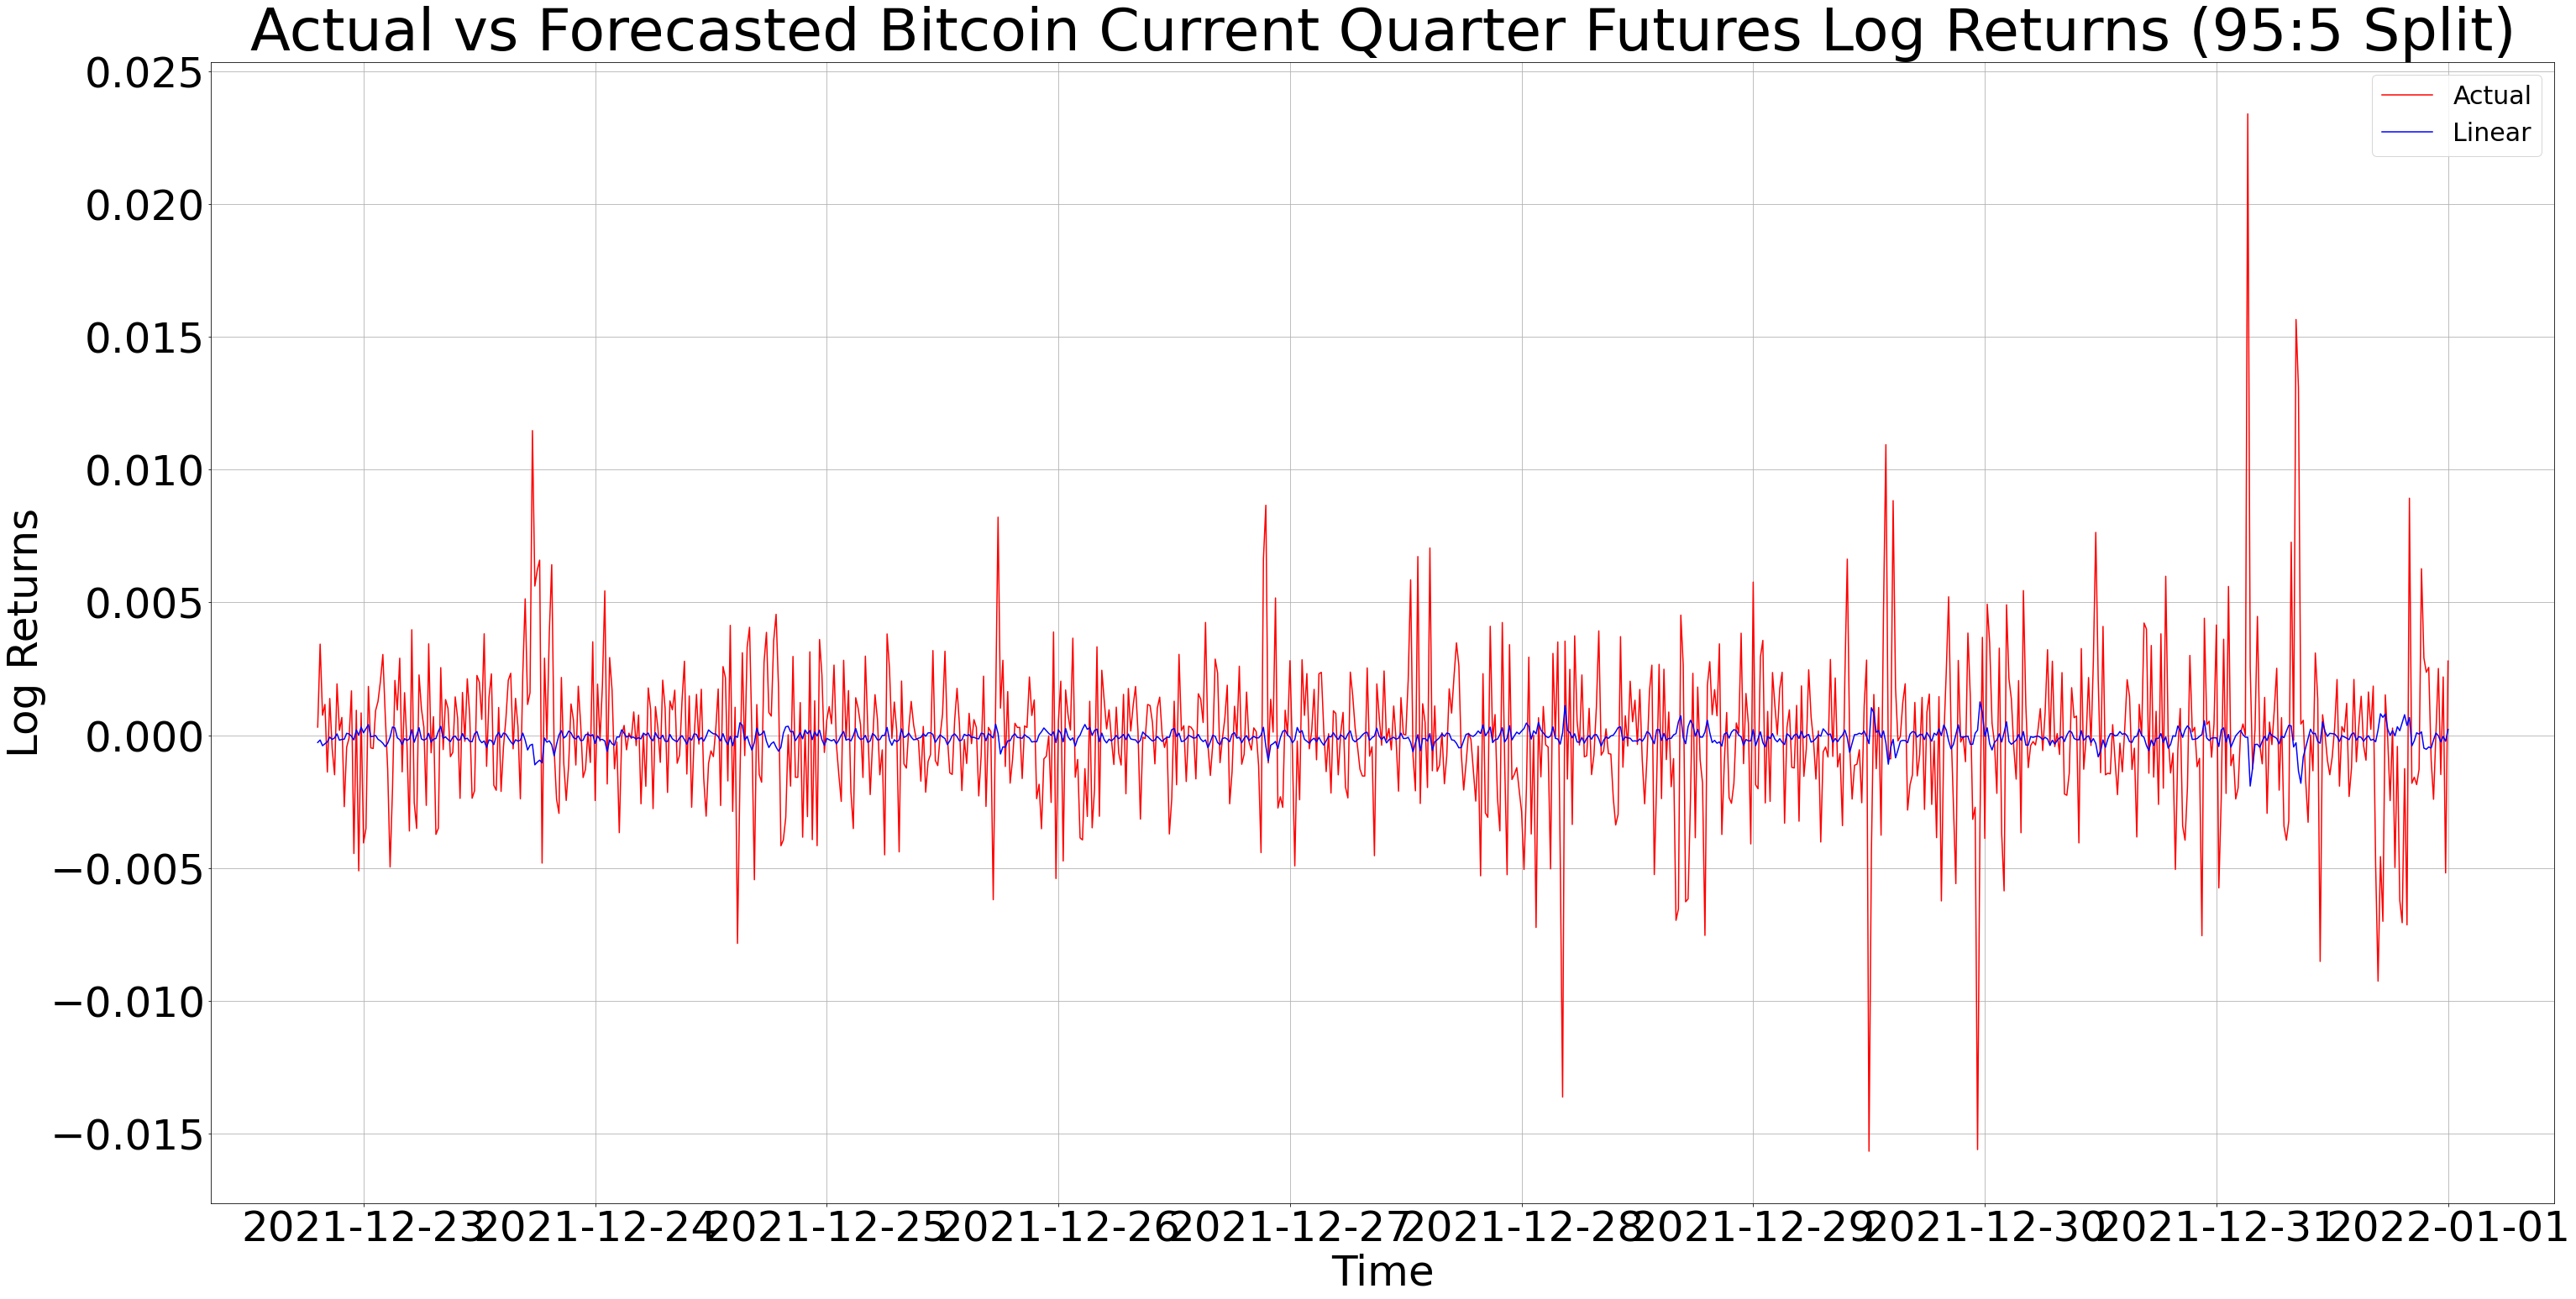

In [191]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (50,25)

ax.plot(test['time'], test['returns'], color='red', label = 'Actual')
ax.plot(test['time'], lin_pred, color='blue', label = 'Linear')

plt.legend(loc="upper right", prop={'size': 30})
plt.grid(True)
ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (95:5 Split)', fontsize=70)

plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/SVR_lin_uni_95.pdf')
plt.show()

In [192]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

lin_mse = round(mse(np.array(test['returns']), lin_pred), ndigits=10)
lin_rmse = round(rmse(np.array(test['returns']), lin_pred), ndigits=10)
lin_mae = round(meanabs(np.array(test['returns']), lin_pred), ndigits=10)

print("Linear MSE:   ", lin_mse)
print("Linear RMSE:  ", lin_rmse)
print("Linear MAE:   ", lin_mae)

Linear MSE:    8.6083e-06
Linear RMSE:   0.0029339975
Linear MAE:    0.0020346163


# Linear Mixed AR - Model Specification (85:15)

In [263]:
# create training sample data set
train_size = int(0.85 * len(main))
train = main[:train_size]
test = main[train_size:]

X = list()
for lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol in zip(train['lag_returns_1'], train['lag_nqf_returns'], train['lag_spot_returns'], train['lag_change_cqf_vol']):
    X.append( [ lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol ] )

In [166]:
parameters = {
    'C' : [ 1, 10, 100, 1000 ], 
    'kernel' : [ 'linear' ], 
    'epsilon' : [ 0.01, 0.001, 0.0001, 0.00001 ] 
}
tscv = TimeSeriesSplit(n_splits=5)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [167]:
lin_svr_2 = GridSearchCV(
    estimator = SVR(), 
    param_grid = parameters,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1,
    verbose = 2
)
lin_svr_2.fit(X, train['returns'])
lin_svr_2.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ...................C=1, epsilon=0.01, kernel=linear; total time=   0.5s
[CV] END ..................C=1, epsilon=0.001, kernel=linear; total time= 3.4min
[CV] END ................C=10, epsilon=0.0001, kernel=linear; total time= 1.4min
[CV] END ................C=10, epsilon=0.0001, kernel=linear; total time=10.6min
[CV] END .................C=100, epsilon=0.01, kernel=linear; total time=   2.7s
[CV] END .................C=100, epsilon=0.01, kernel=linear; total time=   8.9s
[CV] END .................C=100, epsilon=0.01, kernel=linear; total time=  18.2s
[CV] END .................C=100, epsilon=0.01, kernel=linear; total time=  34.5s
[CV] END .................C=100, epsilon=0.01, kernel=linear; total time=  56.1s
[CV] END ................C=100, epsilon=0.001, kernel=linear; total time=18.3min
[CV] END ...............C=100, epsilon=0.0001, kernel=linear; total time=67.2min
[CV] END ................C=1000, epsilon=0.01, k

{'C': 1, 'epsilon': 0.001, 'kernel': 'linear'}

[CV] END ...................C=1, epsilon=0.01, kernel=linear; total time=   2.3s
[CV] END .................C=1, epsilon=0.0001, kernel=linear; total time= 1.7min
[CV] END ..................C=10, epsilon=0.01, kernel=linear; total time=   0.4s
[CV] END ..................C=10, epsilon=0.01, kernel=linear; total time=   1.8s
[CV] END ..................C=10, epsilon=0.01, kernel=linear; total time=   4.2s
[CV] END ..................C=10, epsilon=0.01, kernel=linear; total time=   4.7s
[CV] END ..................C=10, epsilon=0.01, kernel=linear; total time=   8.2s
[CV] END .................C=10, epsilon=0.001, kernel=linear; total time=  56.7s
[CV] END .................C=10, epsilon=0.001, kernel=linear; total time=19.5min
[CV] END ................C=100, epsilon=0.001, kernel=linear; total time=40.7min
[CV] END ...............C=100, epsilon=1e-05, kernel=linear; total time=155.7min
[CV] END ..............C=1000, epsilon=1e-05, kernel=linear; total time=114.7min


In [194]:
C_lin_2 = lin_svr_2.best_params_['C']
epsilon_lin_2 = lin_svr_2.best_params_['epsilon']
lin_svr_2.best_score_

-0.0038065166560347836

In [264]:
lin_svr_model_2 = SVR(
    kernel = 'linear', 
    C = C_lin_2, 
    epsilon = epsilon_lin_2
)
lin_svr_model_2.fit(X, train['returns'])

SVR(C=1, epsilon=0.001, kernel='linear')

In [265]:
# create a 2D list object with the predictors from the testing data: lagged returns
Xtest = list()
for lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol in zip(test['lag_returns_1'], test['lag_nqf_returns'], test['lag_spot_returns'], test['lag_change_cqf_vol']):
    Xtest.append( [ lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol ] )
    
# predict the returns for the training data set using the 3 SVR models. 
lin_pred_2 = lin_svr_model_2.predict(Xtest)

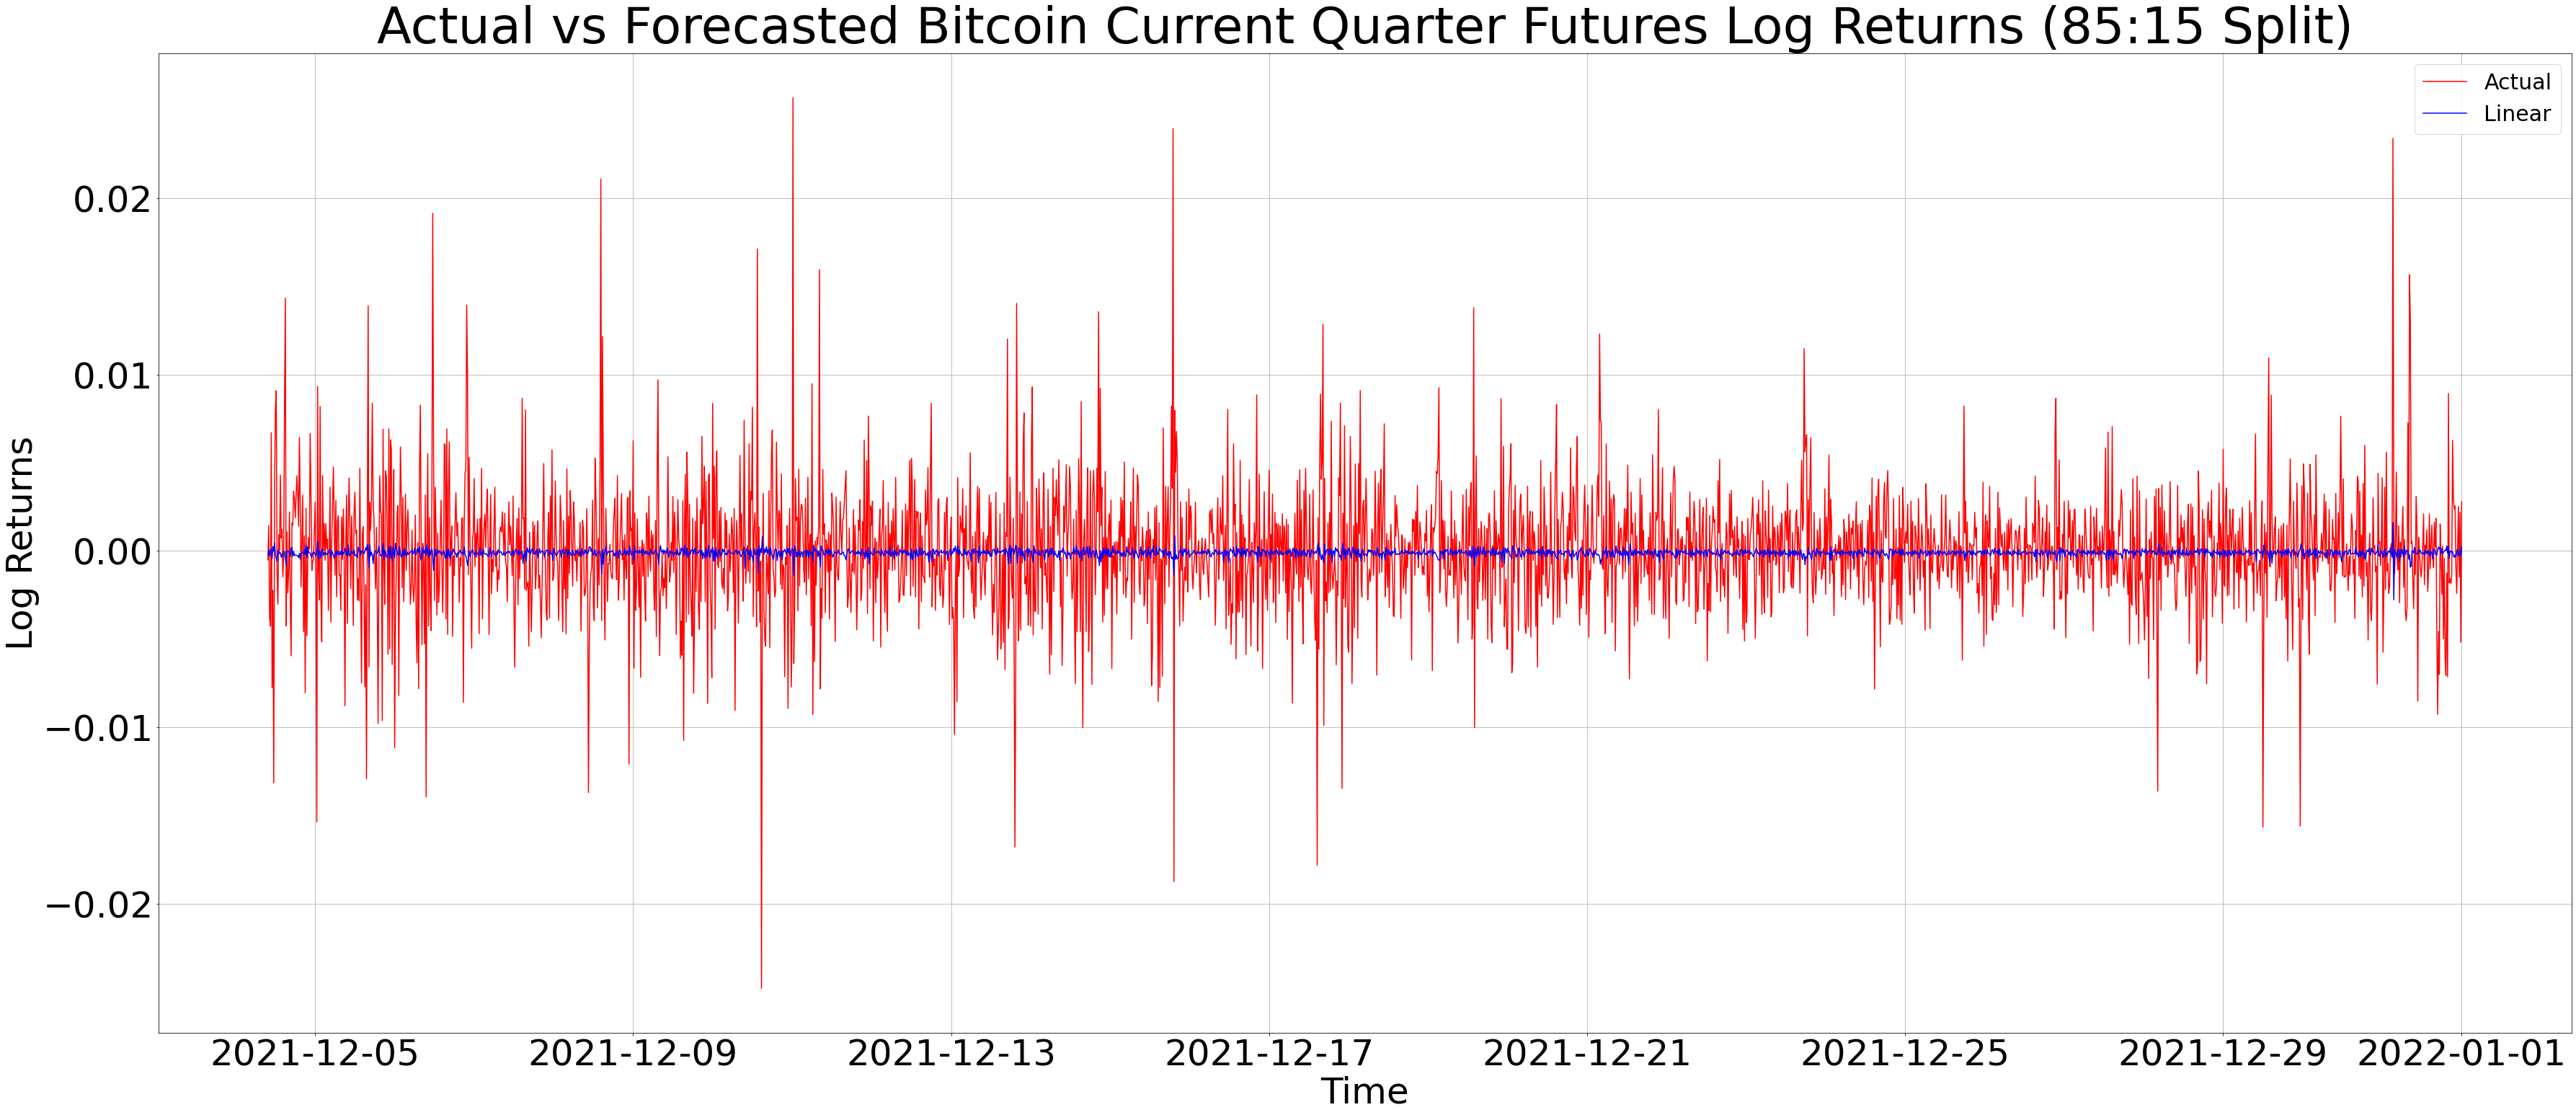

In [269]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (60,25)

ax.plot(test['time'], test['returns'], color='red', label = 'Actual')
ax.plot(test['time'], lin_pred_2, color='blue', label = 'Linear')

plt.legend(loc="upper right", prop={'size': 30})
plt.grid(True)
#ax.set_ylim(-0.1,0.1)
ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (85:15 Split)', fontsize=70)

plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/SVR_lin_model_multi_85.pdf')
plt.show()

In [209]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

lin_mse_2 = round(mse(np.array(test['returns']), lin_pred_2), ndigits=10)
lin_rmse_2 = round(rmse(np.array(test['returns']), lin_pred_2), ndigits=10)
lin_mae_2 = round(meanabs(np.array(test['returns']), lin_pred_2), ndigits=10)

print("Linear MSE:   ", lin_mse_2)
print("Linear RMSE:  ", lin_rmse_2)
print("Linear MAE:   ", lin_mae_2)

Linear MSE:    1.23527e-05
Linear RMSE:   0.0035146454
Linear MAE:    0.0024853549


# Linear Mixed AR - (75:25)

In [199]:
# create training sample data set
train_size = int(0.75 * len(main))
train = main[:train_size]
test = main[train_size:]

X = list()
for lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol in zip(train['lag_returns_1'], train['lag_nqf_returns'], train['lag_spot_returns'], train['lag_change_cqf_vol']):
    X.append( [ lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol ] )

In [200]:
lin_svr_model_2 = SVR(
    kernel = 'linear', 
    C = C_lin_2, 
    epsilon = epsilon_lin_2
)
lin_svr_model_2.fit(X, train['returns'])

SVR(C=1, epsilon=0.001, kernel='linear')

In [201]:
Xtest = list()
for lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol in zip(test['lag_returns_1'], test['lag_nqf_returns'], test['lag_spot_returns'], test['lag_change_cqf_vol']):
    Xtest.append( [ lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol ] )
    
lin_pred_2 = lin_svr_model_2.predict(Xtest)

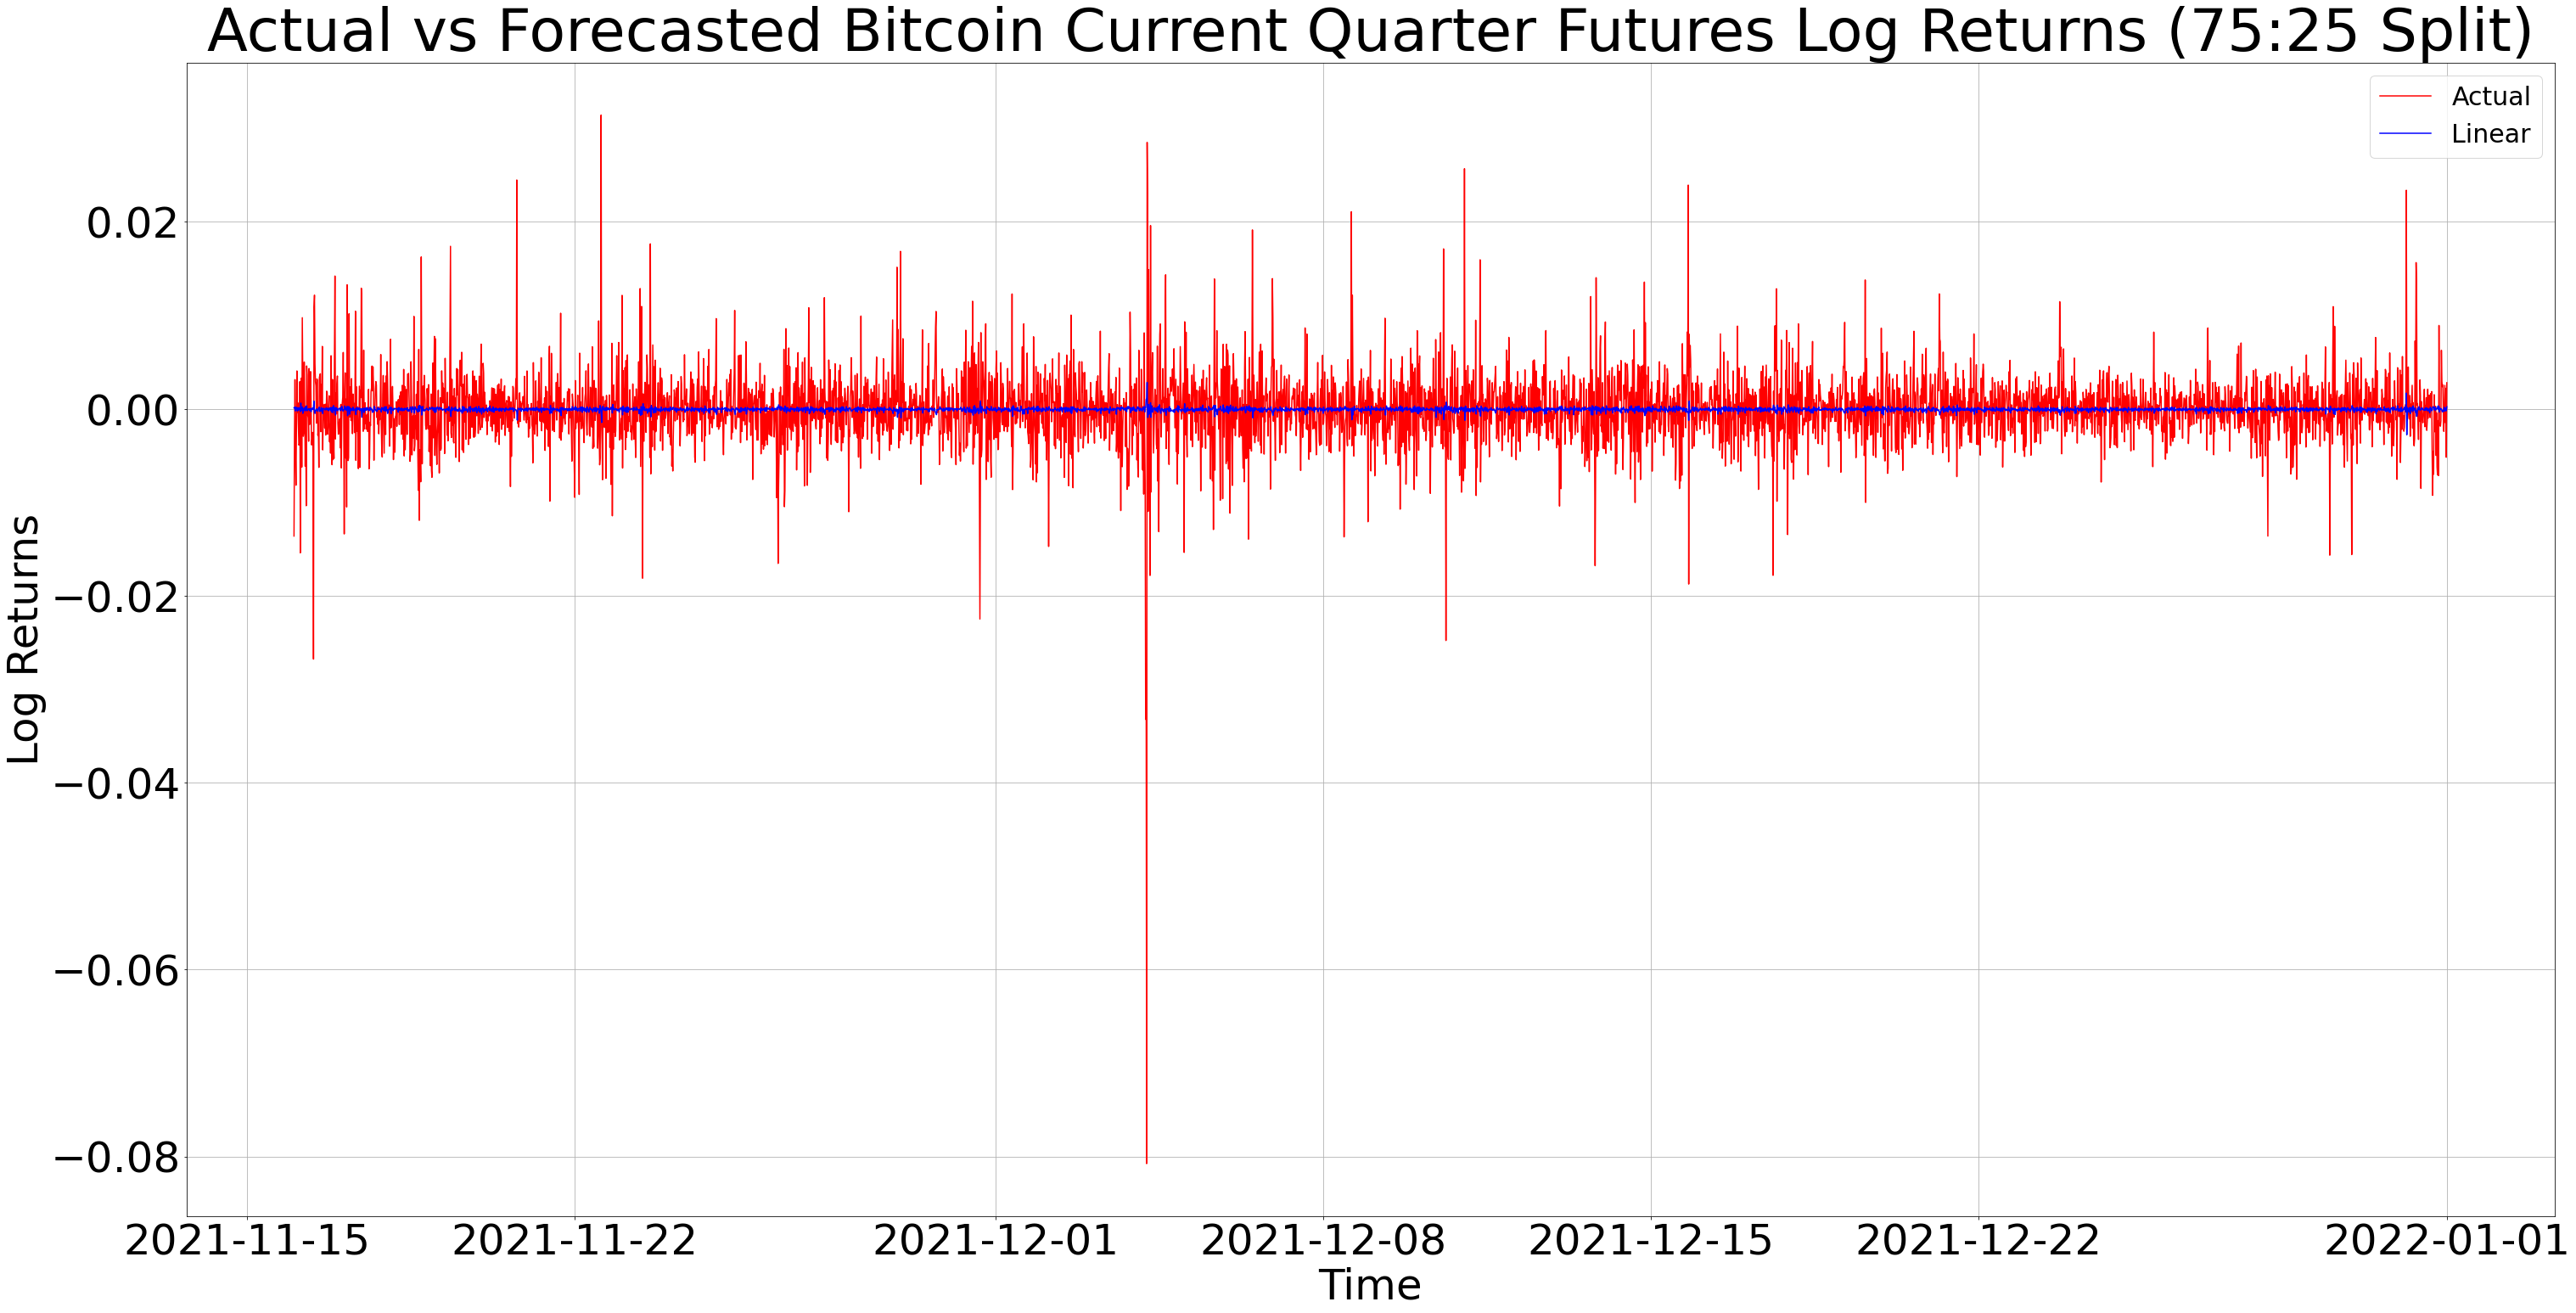

In [202]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (50,25)

ax.plot(test['time'], test['returns'], color='red', label = 'Actual')
ax.plot(test['time'], lin_pred_2, color='blue', label = 'Linear')

plt.legend(loc="upper right", prop={'size': 30})
plt.grid(True)
ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (75:25 Split)', fontsize=70)

plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/SVR_lin_model_multi_75.pdf')
plt.show()

In [204]:
# calculate the MSE for the forecasts of the 3 models
from statsmodels.tools.eval_measures import mse, rmse, meanabs

lin_mse_2 = round(mse(np.array(test['returns']), lin_pred_2), ndigits=10)
lin_rmse_2 = round(rmse(np.array(test['returns']), lin_pred_2), ndigits=10)
lin_mae_2 = round(meanabs(np.array(test['returns']), lin_pred_2), ndigits=10)

print("Linear MSE:   ", lin_mse_2)
print("Linear RMSE:  ", lin_rmse_2)
print("Linear MAE:   ", lin_mae_2)

Linear MSE:    1.57971e-05
Linear RMSE:   0.0039745574
Linear MAE:    0.0026399772


# Linear Mixed AR - (95:5)

In [210]:
train_size = int(0.95 * len(main))
train = main[:train_size]
test = main[train_size:]

X = list()
for lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol in zip(train['lag_returns_1'], train['lag_nqf_returns'], train['lag_spot_returns'], train['lag_change_cqf_vol']):
    X.append( [ lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol ] )

In [211]:
lin_svr_model_2 = SVR(
    kernel = 'linear', 
    C = C_lin_2, 
    epsilon = epsilon_lin_2
)
lin_svr_model_2.fit(X, train['returns'])

SVR(C=1, epsilon=0.001, kernel='linear')

In [212]:
Xtest = list()
for lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol in zip(test['lag_returns_1'], test['lag_nqf_returns'], test['lag_spot_returns'], test['lag_change_cqf_vol']):
    Xtest.append( [ lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol ] )
    
lin_pred_2 = lin_svr_model_2.predict(Xtest)

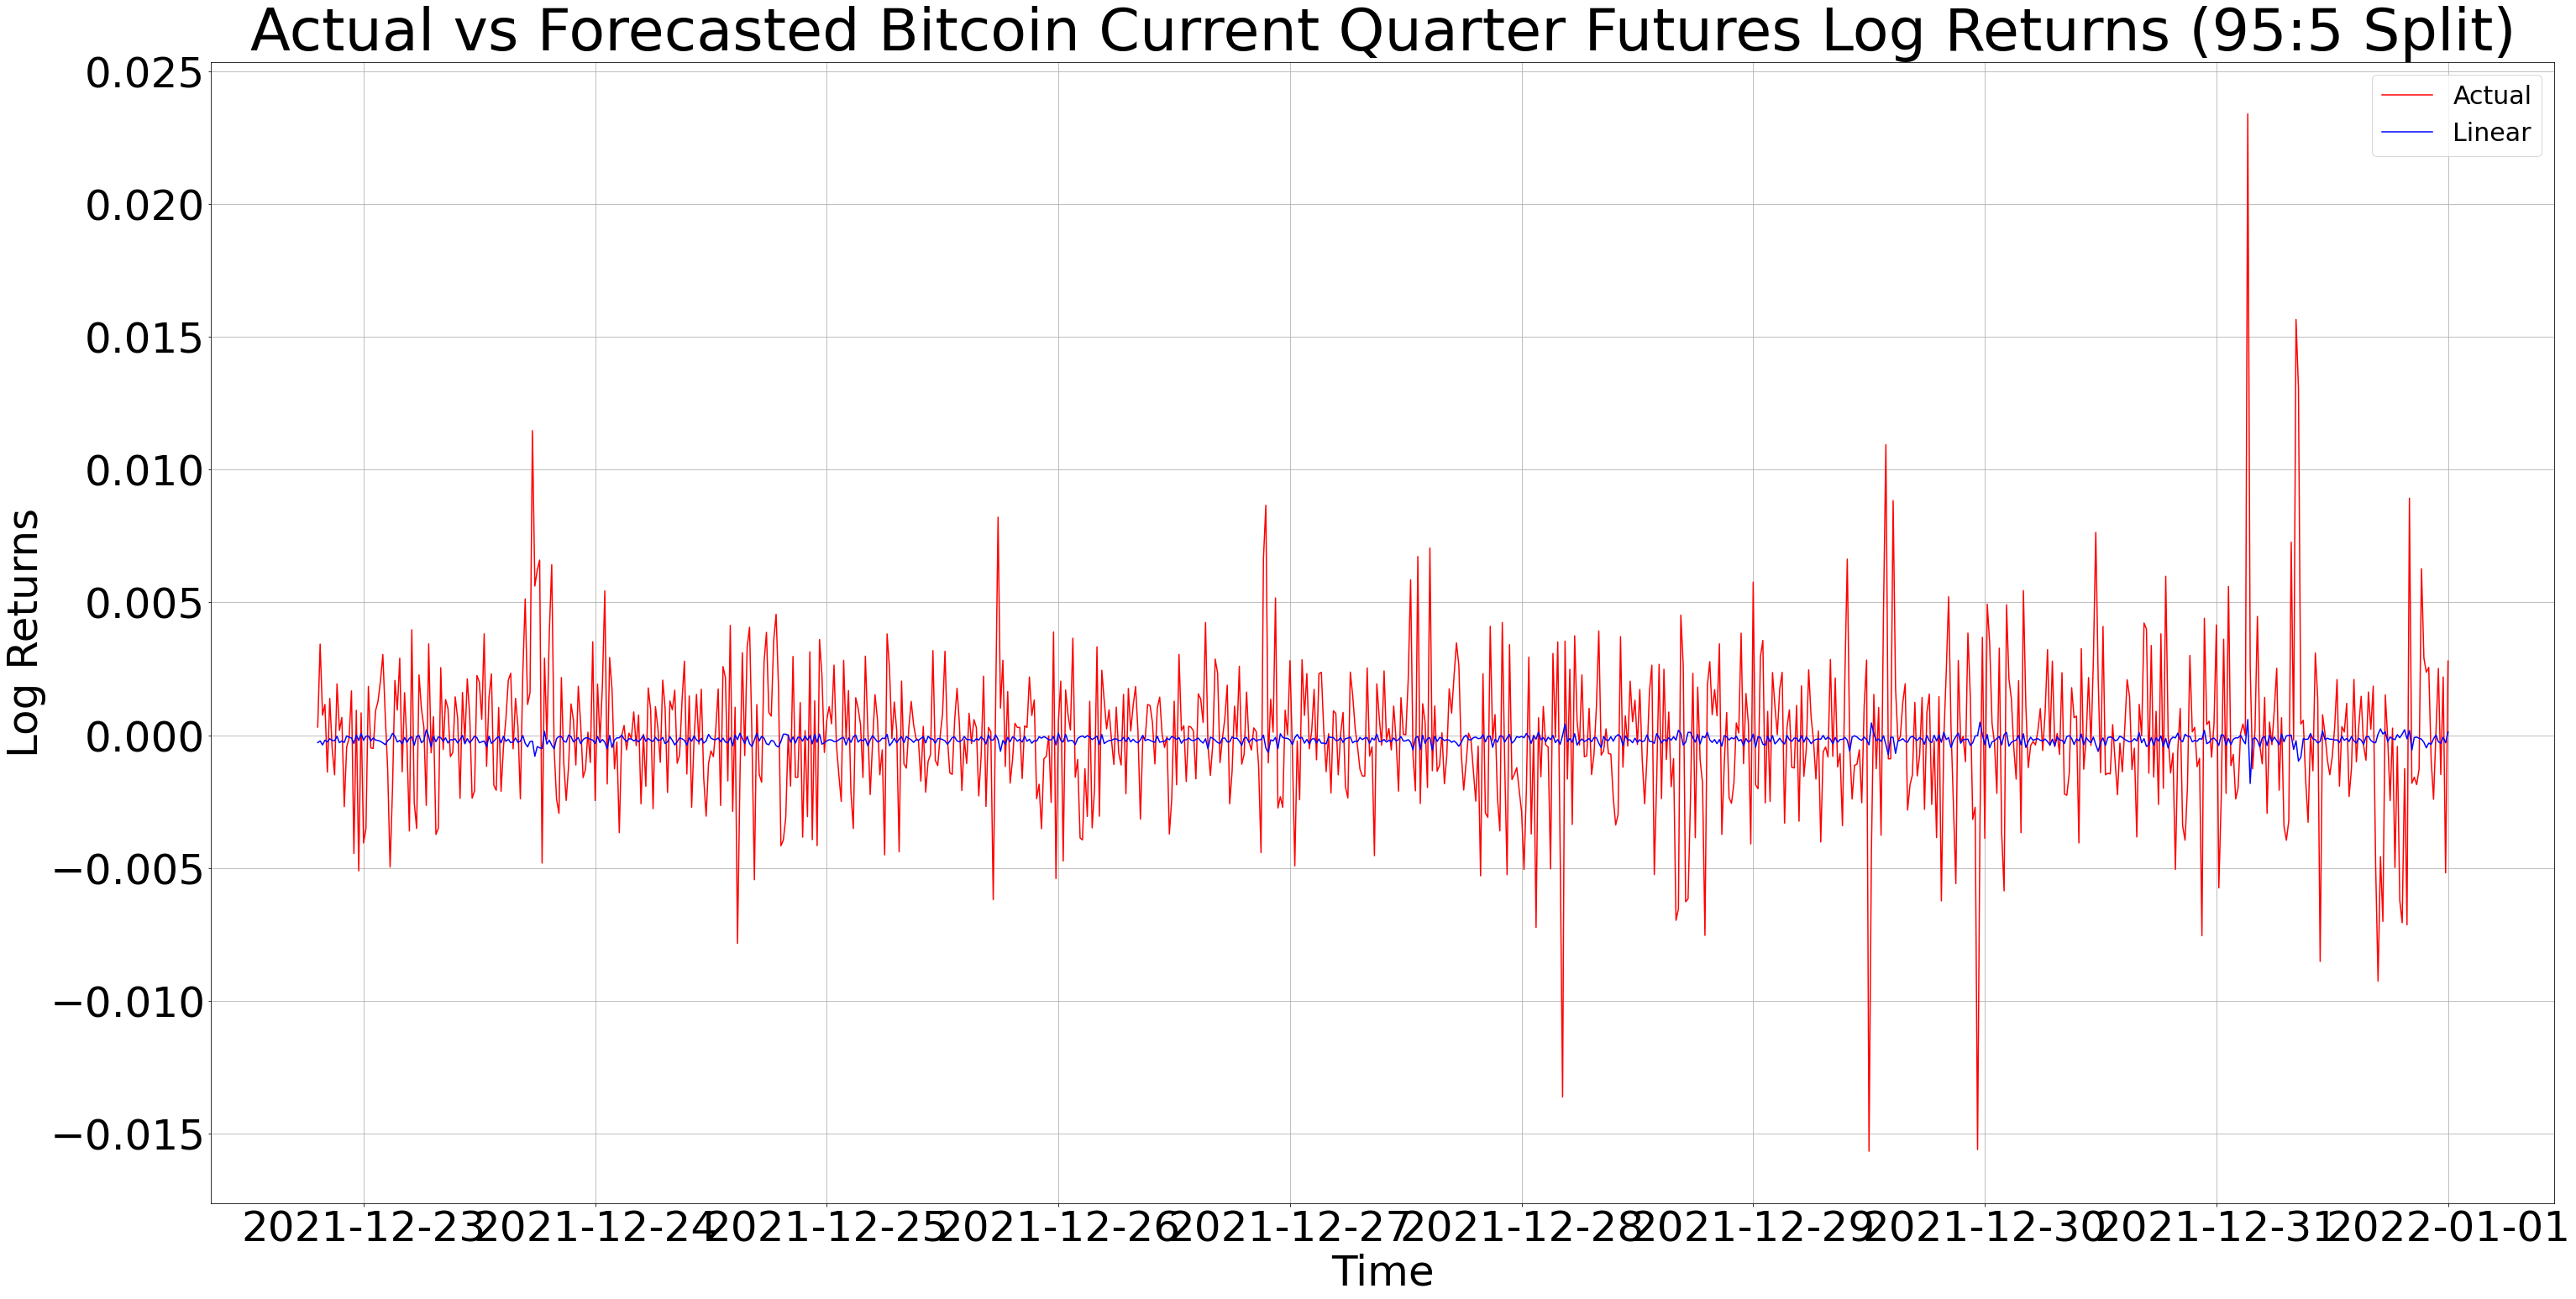

In [213]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (50,25)

ax.plot(test['time'], test['returns'], color='red', label = 'Actual')
ax.plot(test['time'], lin_pred_2, color='blue', label = 'Linear')

plt.legend(loc="upper right", prop={'size': 30})
plt.grid(True)
ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (95:5 Split)', fontsize=70)

plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/SVR_lin_model_multi_95.pdf')
plt.show()

In [214]:
# calculate the MSE for the forecasts of the 3 models
from statsmodels.tools.eval_measures import mse, rmse, meanabs

lin_mse_2 = round(mse(np.array(test['returns']), lin_pred_2), ndigits=10)
lin_rmse_2 = round(rmse(np.array(test['returns']), lin_pred_2), ndigits=10)
lin_mae_2 = round(meanabs(np.array(test['returns']), lin_pred_2), ndigits=10)

print("Linear MSE:   ", lin_mse_2)
print("Linear RMSE:  ", lin_rmse_2)
print("Linear MAE:   ", lin_mae_2)

Linear MSE:    8.5142e-06
Linear RMSE:   0.002917905
Linear MAE:    0.0020387548


# RBF Pure AR - Model Specification (85:15)

In [219]:
train_size = int(0.85 * len(main))
train = main[:train_size]
test = main[train_size:]

X = list()
for lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 in zip(train['lag_returns_1'], train['lag_returns_2'], train['lag_returns_3'], train['lag_returns_4']):
    X.append( [ lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 ] )

In [220]:
parameters = {
    'C' : [ 1, 10, 100, 1000 ], 
    'kernel' : [ 'rbf' ], 
    'epsilon' : [ 0.01, 0.001, 0.0001, 0.00001 ],
    'gamma' : [ 'scale', 'auto' ]
}
tscv = TimeSeriesSplit(n_splits=5)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [221]:
rbf_svr = GridSearchCV(
    estimator = SVR(), 
    param_grid = parameters,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1,
    verbose = 2
)
rbf_svr.fit(X, train['returns'])
rbf_svr.best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ..........C=1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.3s
[CV] END ........C=1, epsilon=0.001, gamma=scale, kernel=rbf; total time=  21.8s
[CV] END .......C=1, epsilon=0.0001, gamma=scale, kernel=rbf; total time= 3.1min
[CV] END ........C=10, epsilon=0.001, gamma=auto, kernel=rbf; total time=  13.9s
[CV] END ......C=10, epsilon=0.0001, gamma=scale, kernel=rbf; total time= 2.4min
[CV] END .......C=10, epsilon=1e-05, gamma=scale, kernel=rbf; total time= 2.6min
[CV] END .......C=10, epsilon=1e-05, gamma=scale, kernel=rbf; total time=13.7min
[CV] END ....C=100, epsilon=0.0001, gamma=scale, kernel=rbf; total time=101.7min
[CV] END ...C=1000, epsilon=0.0001, gamma=scale, kernel=rbf; total time=320.0min
[CV] END ......C=1000, epsilon=1e-05, gamma=auto, kernel=rbf; total time=   3.0s
[CV] END ......C=1000, epsilon=1e-05, gamma=auto, kernel=rbf; total time=   8.2s
[CV] END ......C=1000, epsilon=1e-05, gamma=aut

[CV] END .........C=1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   3.0s
[CV] END .........C=1, epsilon=0.001, gamma=auto, kernel=rbf; total time=   9.5s
[CV] END .......C=1, epsilon=0.0001, gamma=scale, kernel=rbf; total time= 1.4min
[CV] END ........C=1, epsilon=0.0001, gamma=auto, kernel=rbf; total time=  21.8s
[CV] END ........C=1, epsilon=1e-05, gamma=scale, kernel=rbf; total time=  52.1s
[CV] END .......C=10, epsilon=0.001, gamma=scale, kernel=rbf; total time= 3.8min
[CV] END .......C=10, epsilon=1e-05, gamma=scale, kernel=rbf; total time= 8.8min
[CV] END .....C=100, epsilon=0.0001, gamma=scale, kernel=rbf; total time=18.7min
[CV] END ......C=100, epsilon=1e-05, gamma=scale, kernel=rbf; total time=42.9min
[CV] END ....C=1000, epsilon=0.001, gamma=scale, kernel=rbf; total time=260.0min
[CV] END ....C=1000, epsilon=1e-05, gamma=scale, kernel=rbf; total time=373.7min
[CV] END ..........C=1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.2s
[CV] END ..........C=1, epsi

{'C': 1000, 'epsilon': 0.001, 'gamma': 'auto', 'kernel': 'rbf'}

[CV] END .........C=1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   2.2s
[CV] END .........C=1, epsilon=0.001, gamma=auto, kernel=rbf; total time=   5.2s
[CV] END .......C=1, epsilon=0.0001, gamma=scale, kernel=rbf; total time=   7.9s
[CV] END .......C=1, epsilon=0.0001, gamma=scale, kernel=rbf; total time= 1.9min
[CV] END ........C=1, epsilon=1e-05, gamma=scale, kernel=rbf; total time= 1.4min
[CV] END ......C=10, epsilon=0.0001, gamma=scale, kernel=rbf; total time=  36.8s
[CV] END ......C=10, epsilon=0.0001, gamma=scale, kernel=rbf; total time= 8.4min
[CV] END ......C=100, epsilon=0.001, gamma=scale, kernel=rbf; total time=49.7min
[CV] END ......C=1000, epsilon=0.01, gamma=scale, kernel=rbf; total time= 4.7min
[CV] END ....C=1000, epsilon=0.001, gamma=scale, kernel=rbf; total time=115.0min
[CV] END .....C=1000, epsilon=0.0001, gamma=auto, kernel=rbf; total time=   3.9s
[CV] END .....C=1000, epsilon=0.0001, gamma=auto, kernel=rbf; total time=  10.1s
[CV] END .....C=1000, epsilo

In [222]:
C_rbf = rbf_svr.best_params_['C']
epsilon_rbf = rbf_svr.best_params_['epsilon']
gamma_rbf = rbf_svr.best_params_['gamma']
rbf_svr.best_score_

-0.0038023681506082754

In [149]:
rbf_svr_model = SVR(
    kernel = 'rbf', 
    C = C_rbf, 
    epsilon = epsilon_rbf, 
    gamma = gamma_rbf
)
rbf_svr_model.fit(X, train['returns'])

SVR(C=1000, epsilon=0.001, gamma='auto')

In [150]:
Xtest = list()
for lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 in zip(test['lag_returns_1'], test['lag_returns_2'], test['lag_returns_3'], test['lag_returns_4']):
    Xtest.append( [ lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 ] )

rbf_pred = rbf_svr_model.predict(Xtest)

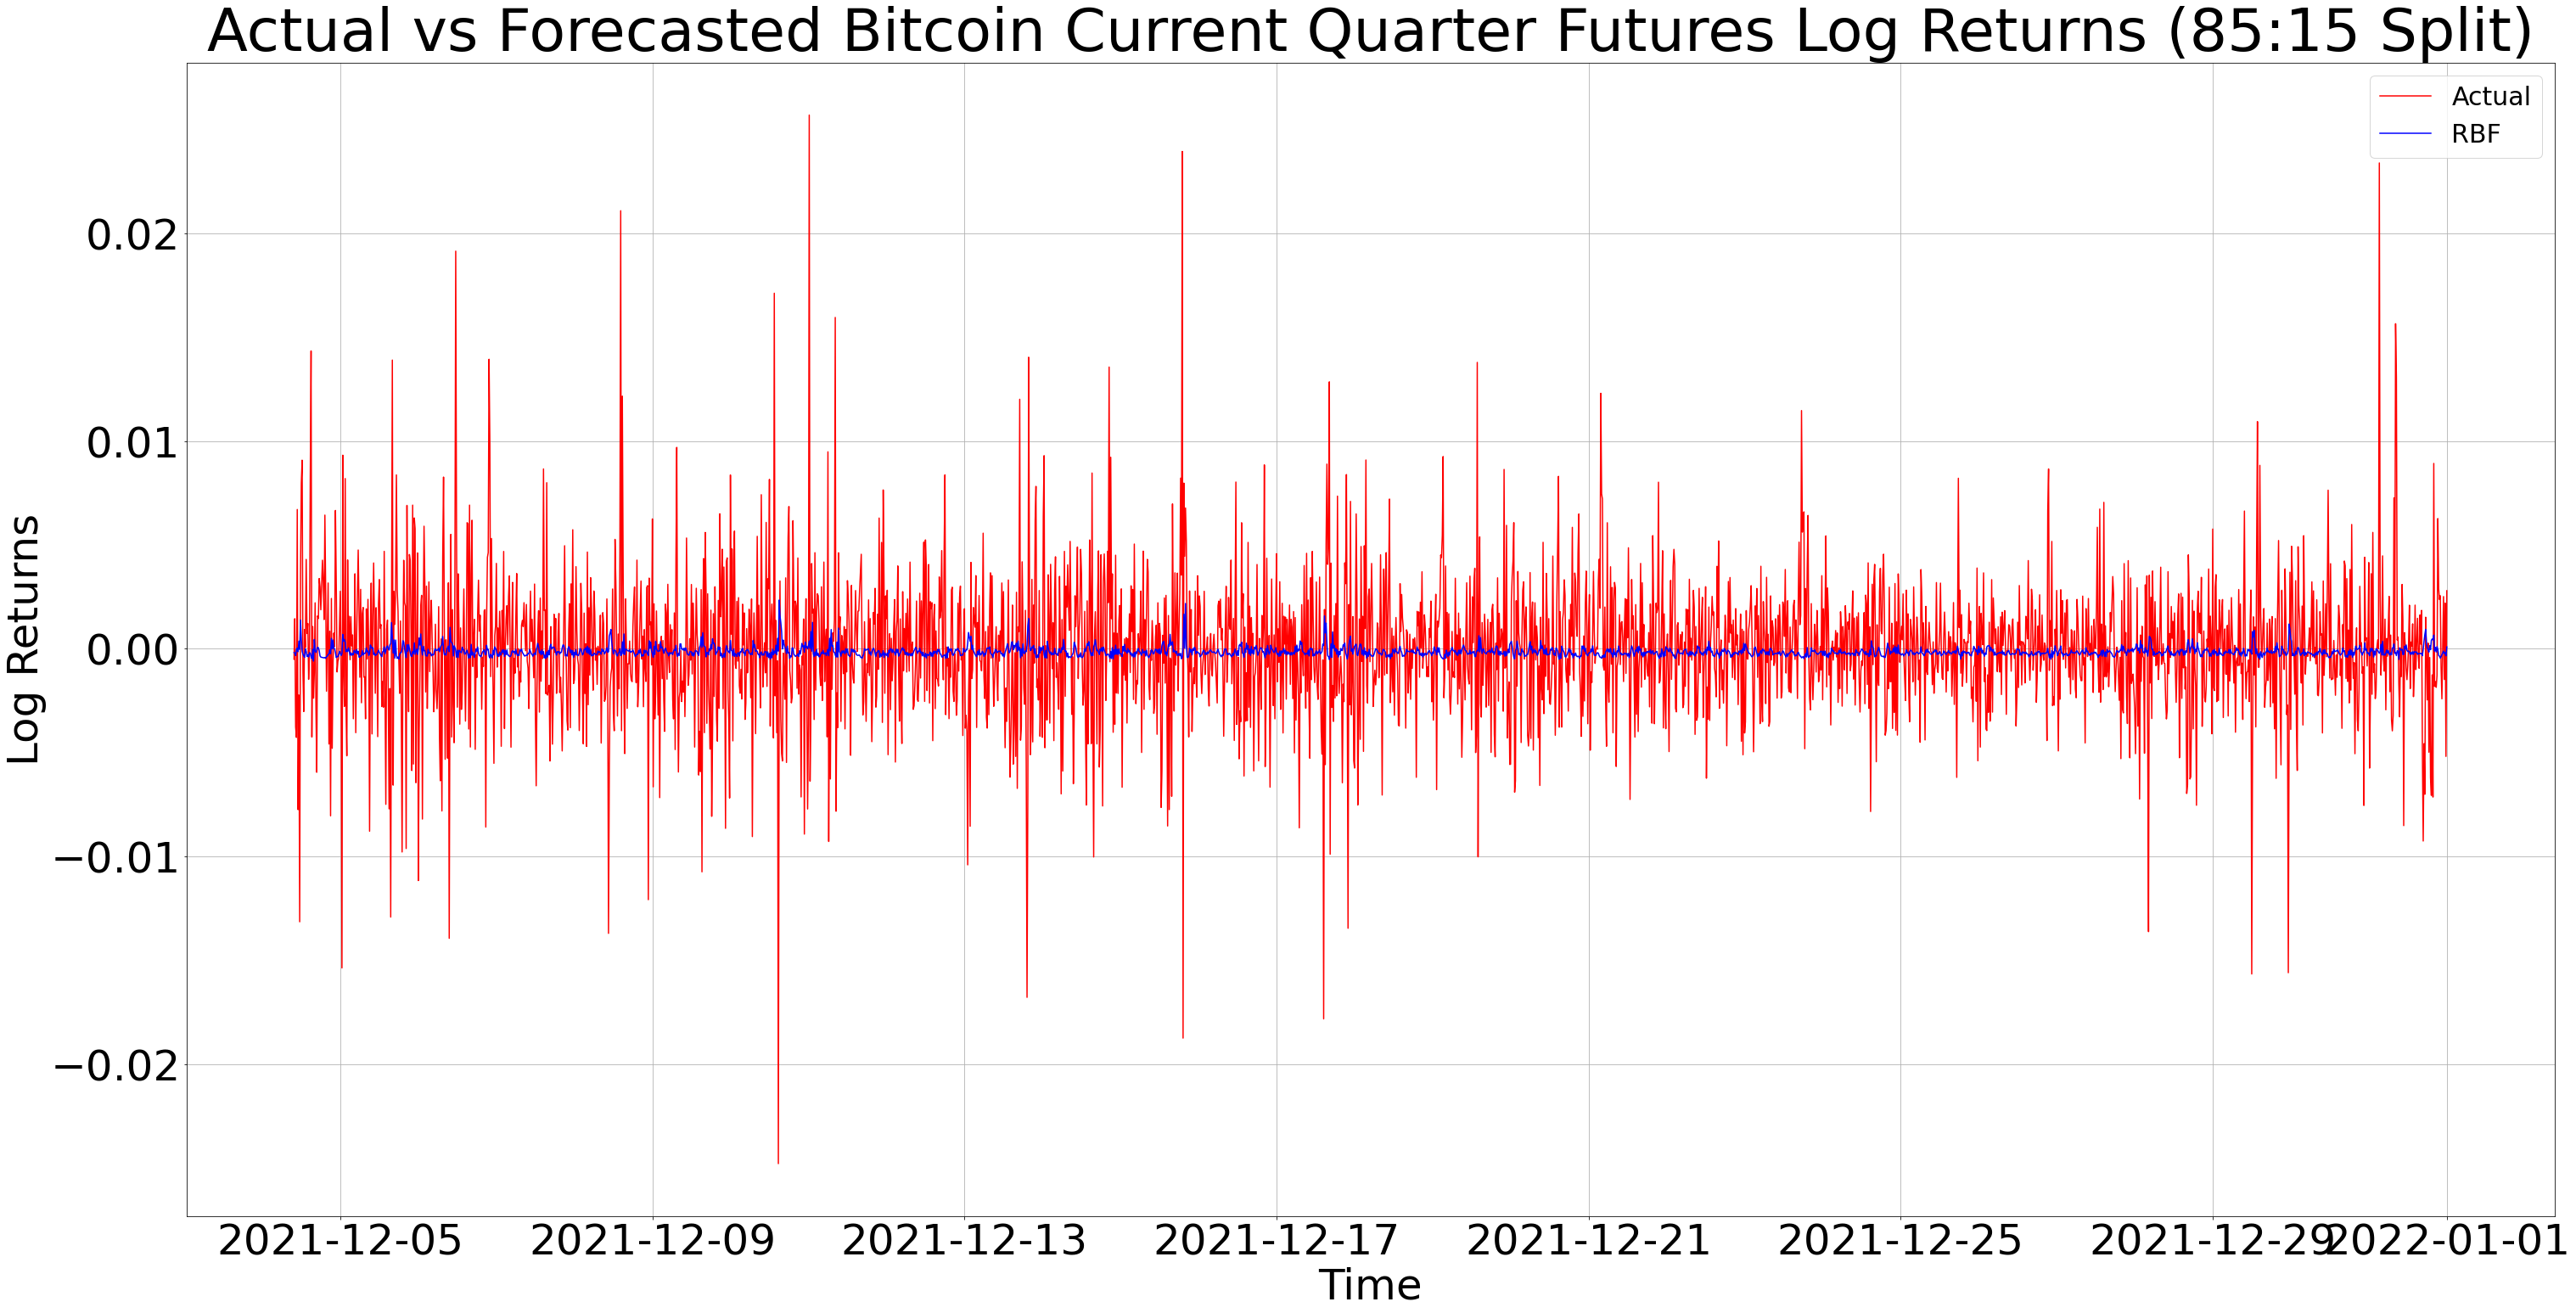

In [225]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (50,25)

ax.plot(test['time'], test['returns'], color='red', label = 'Actual')
ax.plot(test['time'], rbf_pred, color='blue', label = 'RBF')

plt.legend(loc="upper right", prop={'size': 30})
plt.grid(True)
ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (85:15 Split)', fontsize=70)

plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/SVR_rbf_uni_model.pdf')
plt.show()

In [152]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

rbf_mse = round(mse(np.array(test['returns']), rbf_pred), ndigits=10)
rbf_rmse = round(rmse(np.array(test['returns']), rbf_pred), ndigits=10)
rbf_mae = round(meanabs(np.array(test['returns']), rbf_pred), ndigits=10)

print("RBF MSE:    ", rbf_mse)
print("RBF RMSE:   ", rbf_rmse)
print("RBF MAE:    ", rbf_mae)

RBF MSE:     1.23876e-05
RBF RMSE:    0.0035195982
RBF MAE:     0.0024864657


# RBF Pure AR - (75:25)

In [242]:
# create training sample data set
train_size = int(0.75 * len(main))
train = main[:train_size]
test = main[train_size:]

X = list()
for lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 in zip(train['lag_returns_1'], train['lag_returns_2'], train['lag_returns_3'], train['lag_returns_4']):
    X.append( [ lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 ] )

In [243]:
rbf_svr_model = SVR(
    kernel = 'rbf', 
    C = C_rbf, 
    epsilon = epsilon_rbf, 
    gamma = gamma_rbf
)
rbf_svr_model.fit(X, train['returns'])

SVR(C=1000, epsilon=0.001, gamma='auto')

In [244]:

Xtest = list()
for lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 in zip(test['lag_returns_1'], test['lag_returns_2'], test['lag_returns_3'], test['lag_returns_4']):
    Xtest.append( [ lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 ] )


rbf_pred = rbf_svr_model.predict(Xtest)

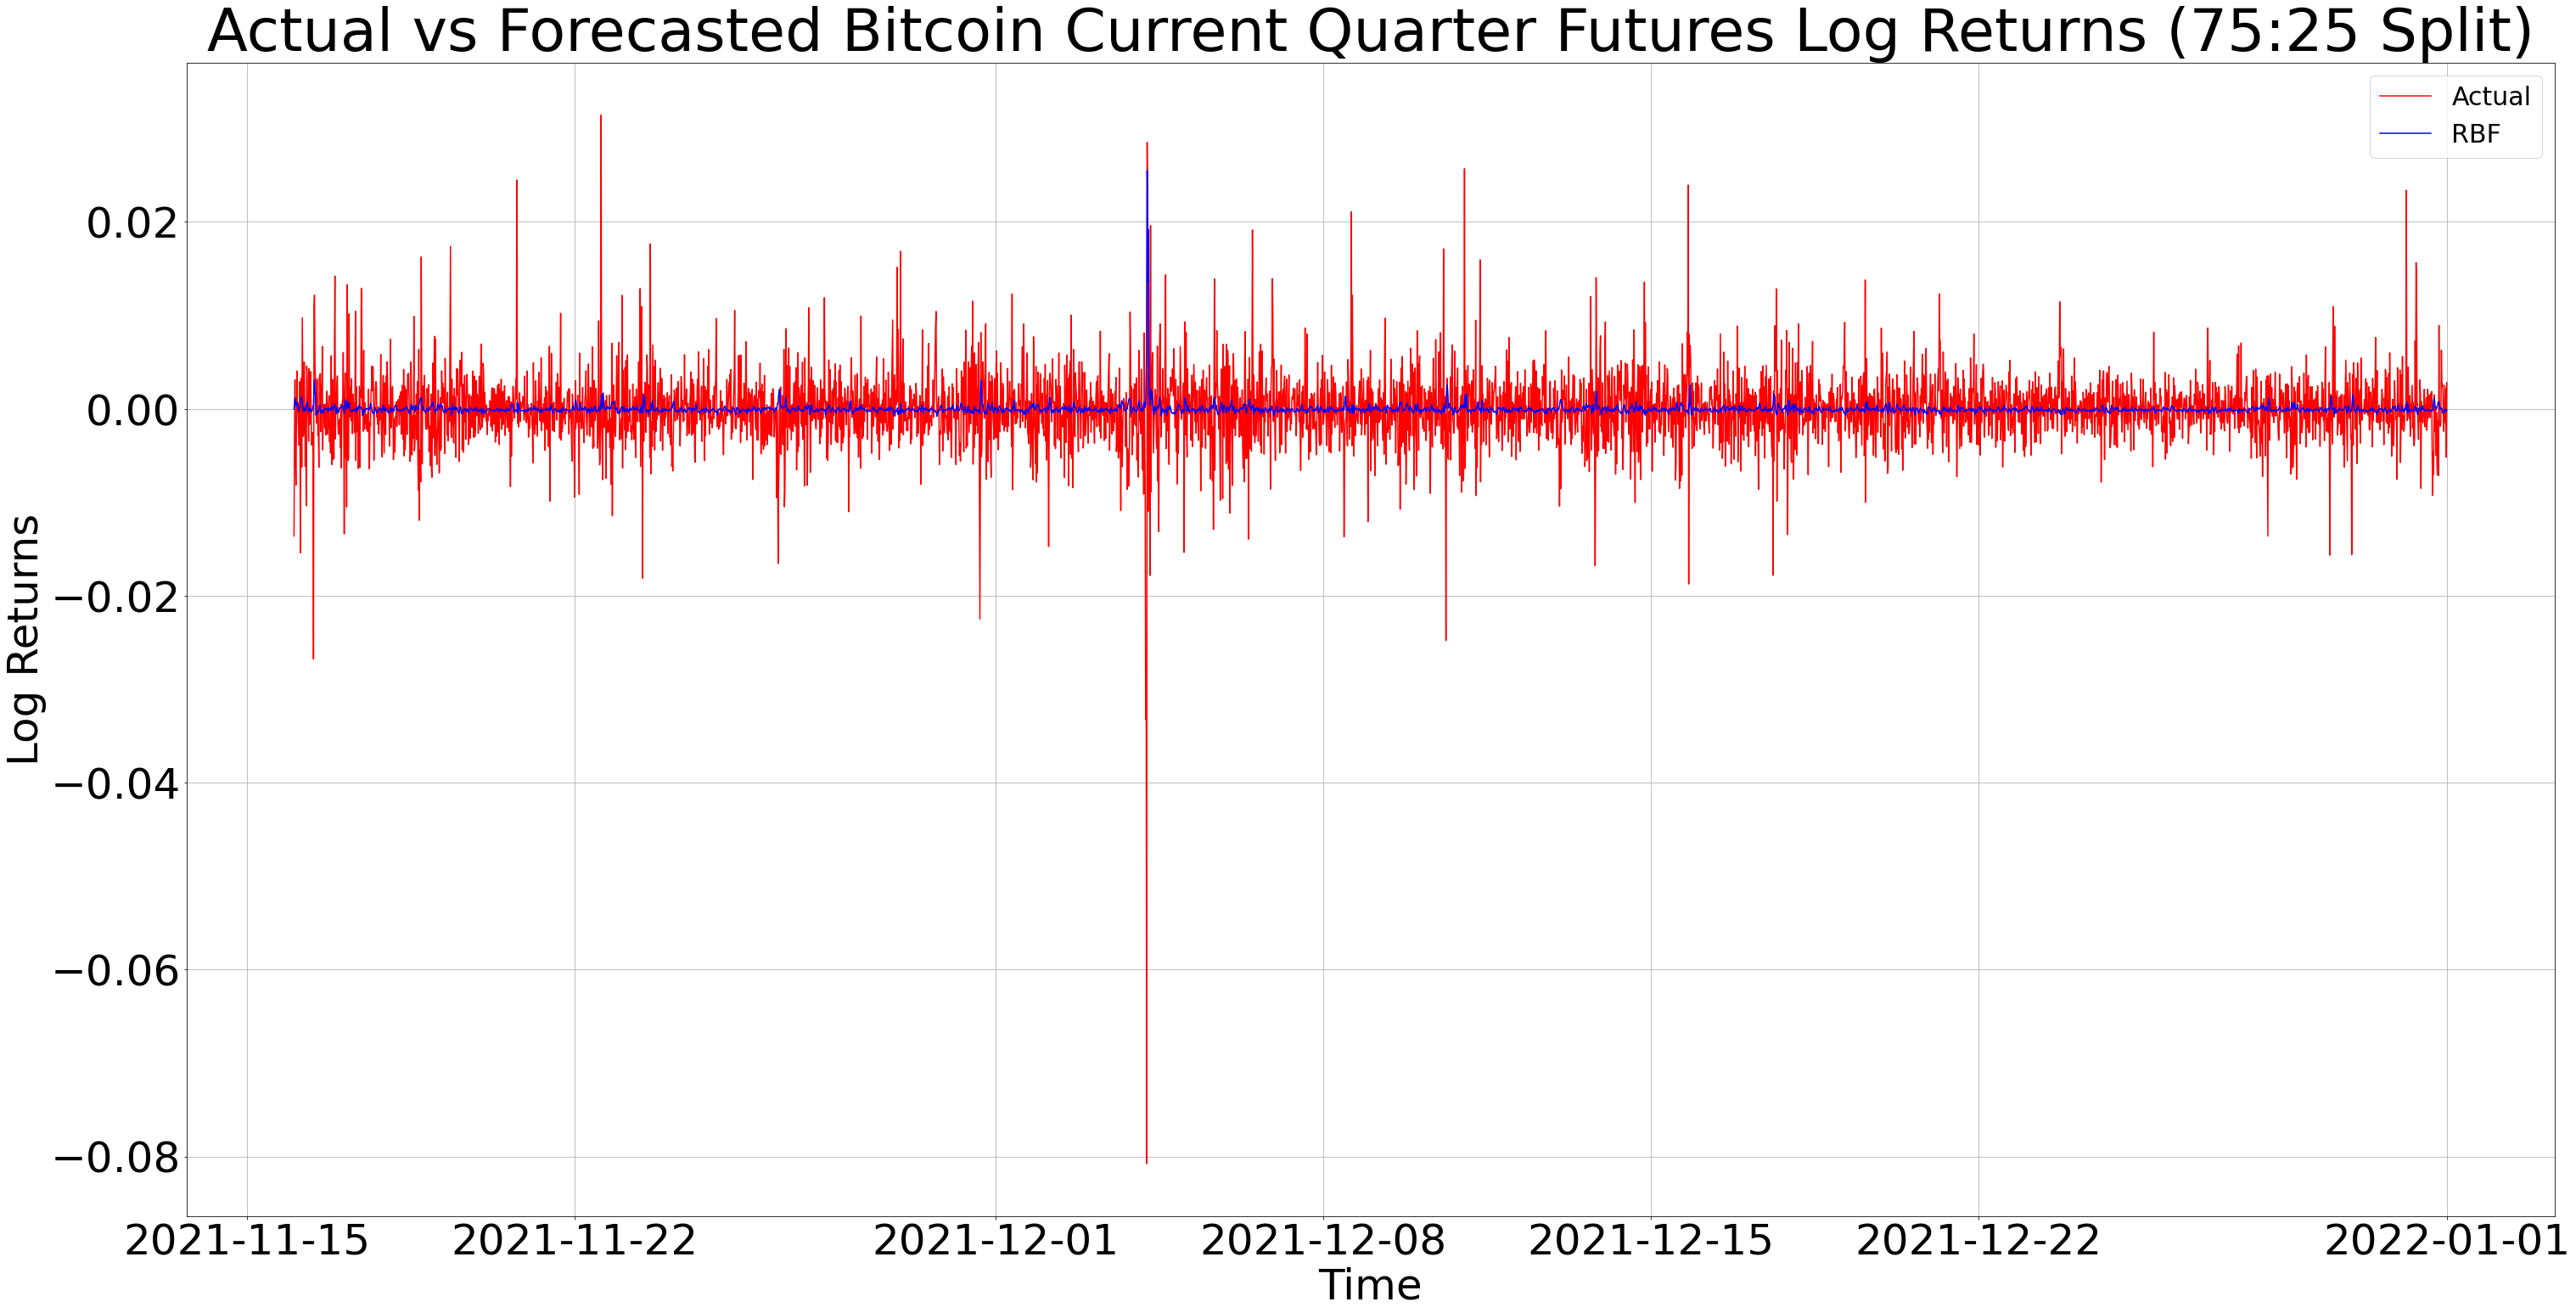

In [245]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (50,25)

ax.plot(test['time'], test['returns'], color='red', label = 'Actual')
ax.plot(test['time'], rbf_pred, color='blue', label = 'RBF')

plt.legend(loc="upper right", prop={'size': 30})
plt.grid(True)
ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (75:25 Split)', fontsize=70)

plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/SVR_rbf_uni_75.pdf')
plt.show()

In [246]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

rbf_mse = round(mse(np.array(test['returns']), rbf_pred), ndigits=10)
rbf_rmse = round(rmse(np.array(test['returns']), rbf_pred), ndigits=10)
rbf_mae = round(meanabs(np.array(test['returns']), rbf_pred), ndigits=10)

print("RBF MSE:    ", rbf_mse)
print("RBF RMSE:   ", rbf_rmse)
print("RBF MAE:    ", rbf_mae)

RBF MSE:     1.59109e-05
RBF RMSE:    0.0039888512
RBF MAE:     0.0026354439


# RBF Pure AR (95:5) 

In [237]:
# create training sample data set
train_size = int(0.95 * len(main))
train = main[:train_size]
test = main[train_size:]

X = list()
for lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 in zip(train['lag_returns_1'], train['lag_returns_2'], train['lag_returns_3'], train['lag_returns_4']):
    X.append( [ lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 ] )

In [238]:
rbf_svr_model = SVR(
    kernel = 'rbf', 
    C = C_rbf, 
    epsilon = epsilon_rbf, 
    gamma = gamma_rbf
)
rbf_svr_model.fit(X, train['returns'])

SVR(C=1000, epsilon=0.001, gamma='auto')

In [239]:
Xtest = list()
for lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 in zip(test['lag_returns_1'], test['lag_returns_2'], test['lag_returns_3'], test['lag_returns_4']):
    Xtest.append( [ lag_returns_1, lag_returns_2, lag_returns_3, lag_returns_4 ] )

rbf_pred = rbf_svr_model.predict(Xtest)

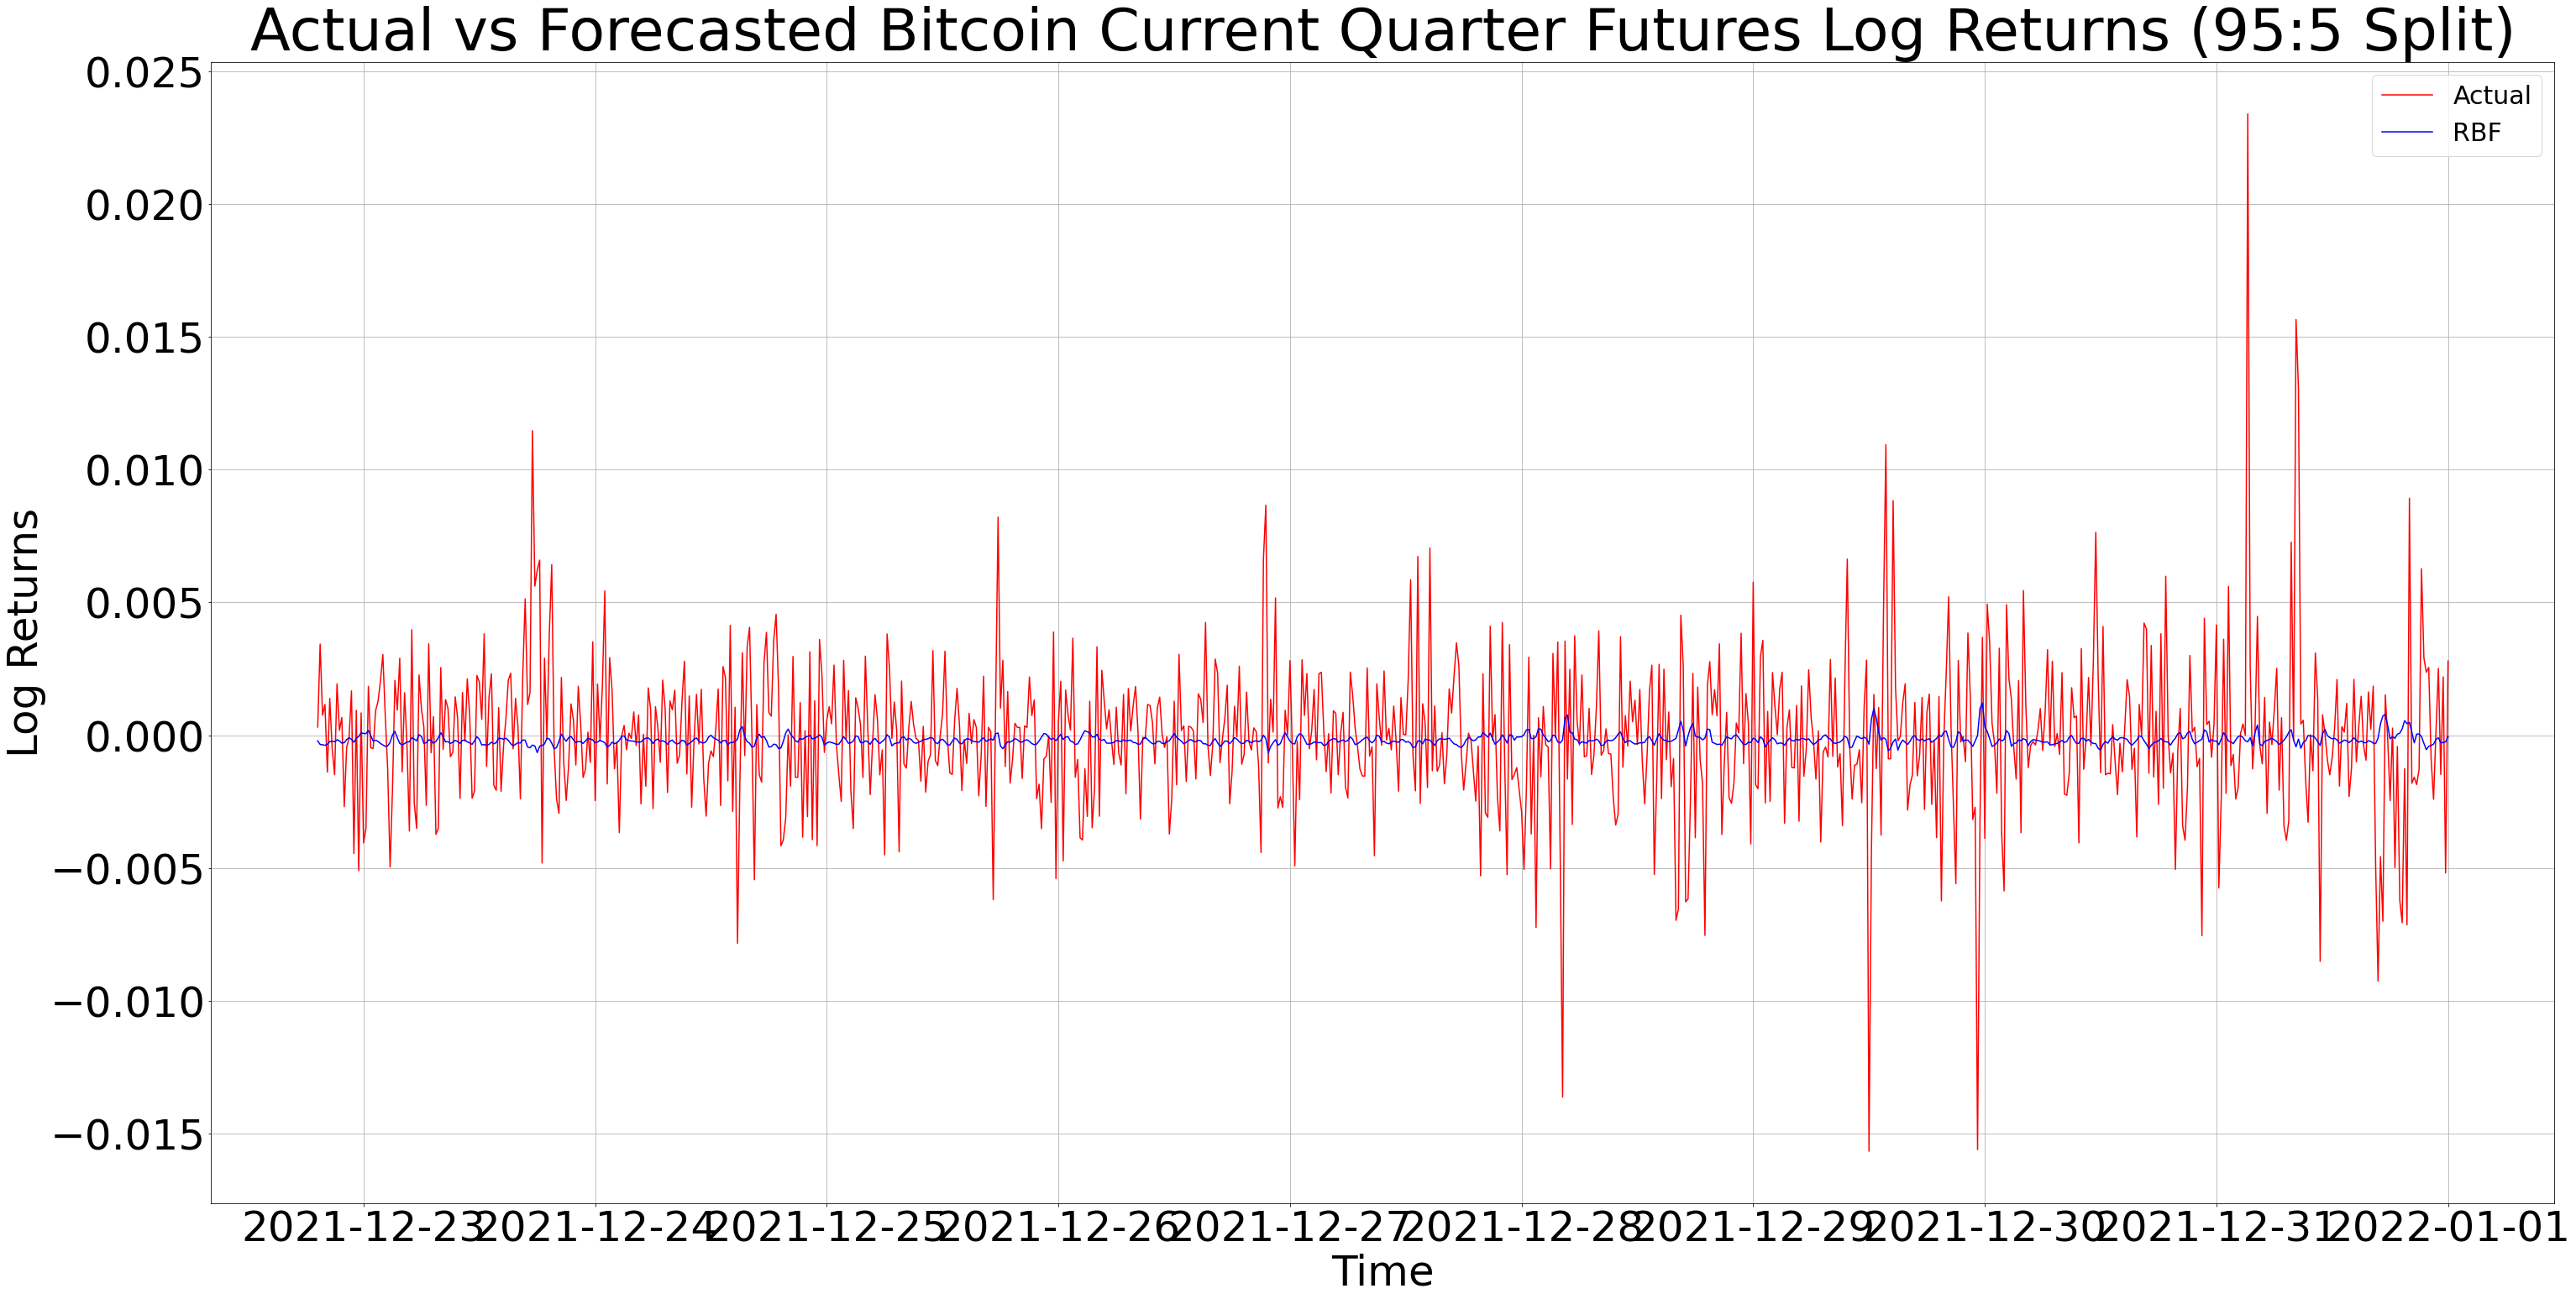

In [240]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (50,25)

ax.plot(test['time'], test['returns'], color='red', label = 'Actual')
ax.plot(test['time'], rbf_pred, color='blue', label = 'RBF')

plt.legend(loc="upper right", prop={'size': 30})
plt.grid(True)
ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (95:5 Split)', fontsize=70)

plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/SVR_rbf_uni_95.pdf')
plt.show()

In [241]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

rbf_mse = round(mse(np.array(test['returns']), rbf_pred), ndigits=10)
rbf_rmse = round(rmse(np.array(test['returns']), rbf_pred), ndigits=10)
rbf_mae = round(meanabs(np.array(test['returns']), rbf_pred), ndigits=10)

print("RBF MSE:    ", rbf_mse)
print("RBF RMSE:   ", rbf_rmse)
print("RBF MAE:    ", rbf_mae)

RBF MSE:     8.539e-06
RBF RMSE:    0.0029221538
RBF MAE:     0.0020378114


# RBF Mixed AR - Model Specification (85:15)

In [247]:
# create training sample data set
train_size = int(0.85 * len(main))
train = main[:train_size]
test = main[train_size:]

X = list()
for lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol in zip(train['lag_returns_1'], train['lag_nqf_returns'], train['lag_spot_returns'], train['lag_change_cqf_vol']):
    X.append( [ lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol ] )

In [216]:
parameters = {
    'C' : [ 1, 10, 100, 1000 ], 
    'kernel' : [ 'rbf' ], 
    'epsilon' : [ 0.01, 0.001, 0.0001, 0.00001 ],
    'gamma' : [ 'scale', 'auto' ]
}
tscv = TimeSeriesSplit(n_splits=5)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [218]:
rbf_svr_2 = GridSearchCV(
    estimator = SVR(), 
    param_grid = parameters,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1,
    verbose = 2
)
rbf_svr_2.fit(X, train['returns'])
rbf_svr_2.best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


{'C': 1, 'epsilon': 0.001, 'gamma': 'auto', 'kernel': 'rbf'}

[CV] END ..........C=1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.3s
[CV] END ........C=1, epsilon=0.001, gamma=scale, kernel=rbf; total time=   8.0s
[CV] END .......C=1, epsilon=0.0001, gamma=scale, kernel=rbf; total time=  19.4s
[CV] END .........C=1, epsilon=1e-05, gamma=auto, kernel=rbf; total time=   2.8s
[CV] END .........C=1, epsilon=1e-05, gamma=auto, kernel=rbf; total time=  12.6s
[CV] END .......C=10, epsilon=0.001, gamma=scale, kernel=rbf; total time=  22.4s
[CV] END .......C=10, epsilon=0.0001, gamma=auto, kernel=rbf; total time=   3.4s
[CV] END .......C=10, epsilon=0.0001, gamma=auto, kernel=rbf; total time=   8.1s
[CV] END .......C=10, epsilon=0.0001, gamma=auto, kernel=rbf; total time=  34.8s
[CV] END ......C=100, epsilon=0.001, gamma=scale, kernel=rbf; total time=  23.2s
[CV] END .....C=100, epsilon=0.0001, gamma=scale, kernel=rbf; total time=  27.7s
[CV] END ......C=100, epsilon=0.0001, gamma=auto, kernel=rbf; total time=  18.0s
[CV] END ......C=100, epsilo

[CV] END .........C=1, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END ..........C=1, epsilon=0.01, gamma=auto, kernel=rbf; total time=   0.8s
[CV] END .........C=1, epsilon=0.001, gamma=auto, kernel=rbf; total time=   7.7s
[CV] END .......C=1, epsilon=0.0001, gamma=scale, kernel=rbf; total time=  29.0s
[CV] END ........C=10, epsilon=0.01, gamma=scale, kernel=rbf; total time=   1.7s
[CV] END .........C=10, epsilon=0.01, gamma=auto, kernel=rbf; total time=   1.3s
[CV] END .......C=10, epsilon=0.001, gamma=scale, kernel=rbf; total time=   8.0s
[CV] END ........C=10, epsilon=0.001, gamma=auto, kernel=rbf; total time=   6.4s
[CV] END ........C=10, epsilon=0.001, gamma=auto, kernel=rbf; total time=  26.3s
[CV] END .......C=10, epsilon=1e-05, gamma=scale, kernel=rbf; total time=  18.5s
[CV] END .......C=100, epsilon=0.01, gamma=scale, kernel=rbf; total time=   0.5s
[CV] END .......C=100, epsilon=0.01, gamma=scale, kernel=rbf; total time=   1.4s
[CV] END .......C=100, epsil

In [223]:
C_rbf_2 = rbf_svr_2.best_params_['C']
epsilon_rbf_2 = rbf_svr_2.best_params_['epsilon']
gamma_rbf_2 = rbf_svr_2.best_params_['gamma']
rbf_svr_2.best_score_

-0.0038018259319679637

In [248]:
rbf_svr_model_2 = SVR(
    kernel = 'rbf', 
    C = C_rbf_2, 
    epsilon = epsilon_rbf_2, 
    gamma = gamma_rbf_2
)
rbf_svr_model_2.fit(X, train['returns'])

SVR(C=1, epsilon=0.001, gamma='auto')

In [249]:
Xtest = list()
for lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol in zip(test['lag_returns_1'], test['lag_nqf_returns'], test['lag_spot_returns'], test['lag_change_cqf_vol']):
    Xtest.append( [ lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol ] )

rbf_pred_2 = rbf_svr_model_2.predict(Xtest)

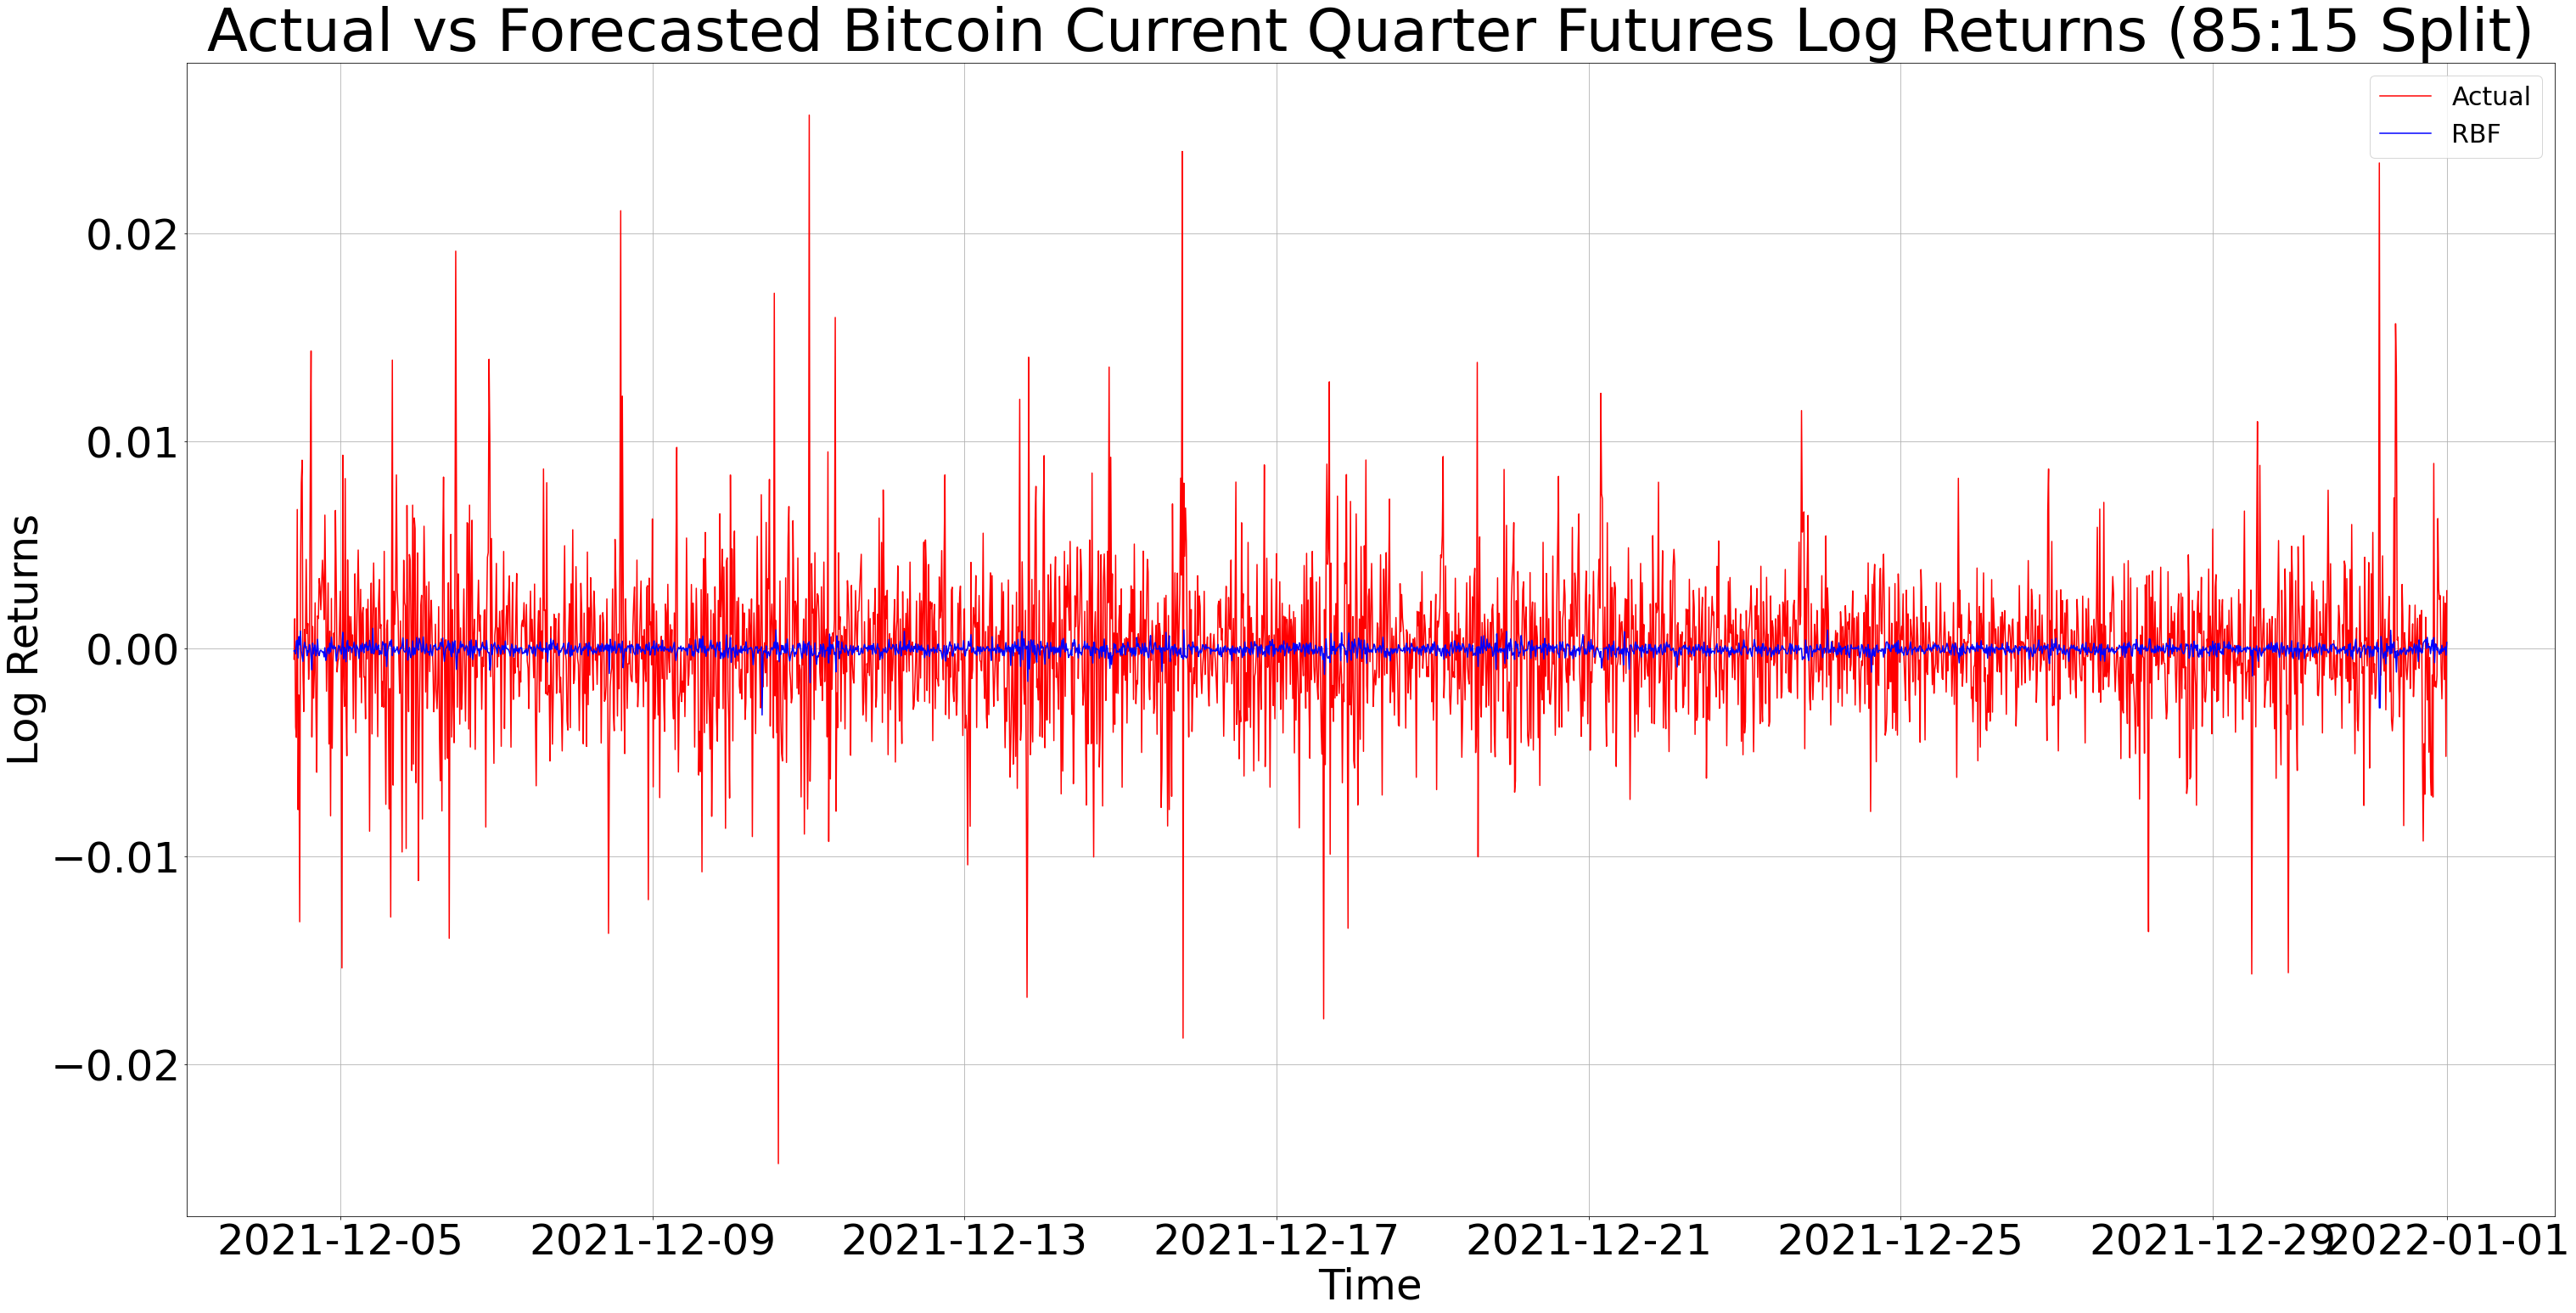

In [250]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (50,25)

ax.plot(test['time'], test['returns'], color='red', label = 'Actual')
ax.plot(test['time'], rbf_pred_2, color='blue', label = 'RBF')

plt.legend(loc="upper right", prop={'size': 30})
plt.grid(True)
ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (85:15 Split)', fontsize=70)

plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/SVR_rbf_multi_85.pdf')
plt.show()

In [251]:
# calculate the accuracy for the forecasts of the model
from statsmodels.tools.eval_measures import mse, rmse, meanabs

rbf_mse = round(mse(np.array(test['returns']), rbf_pred_2), ndigits=10)
rbf_rmse = round(rmse(np.array(test['returns']), rbf_pred_2), ndigits=10)
rbf_mae = round(meanabs(np.array(test['returns']), rbf_pred_2), ndigits=10)

print("RBF MSE:    ", rbf_mse)
print("RBF RMSE:   ", rbf_rmse)
print("RBF MAE:    ", rbf_mae)

RBF MSE:     1.24205e-05
RBF RMSE:    0.003524274
RBF MAE:     0.0024854722


# RBF Mixed AR (75:25)

In [252]:
train_size = int(0.75 * len(main))
train = main[:train_size]
test = main[train_size:]

X = list()
for lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol in zip(train['lag_returns_1'], train['lag_nqf_returns'], train['lag_spot_returns'], train['lag_change_cqf_vol']):
    X.append( [ lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol ] )

In [253]:
rbf_svr_model_2 = SVR(
    kernel = 'rbf', 
    C = C_rbf_2, 
    epsilon = epsilon_rbf_2, 
    gamma = gamma_rbf_2
)
rbf_svr_model_2.fit(X, train['returns'])

SVR(C=1, epsilon=0.001, gamma='auto')

In [254]:
Xtest = list()
for lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol in zip(test['lag_returns_1'], test['lag_nqf_returns'], test['lag_spot_returns'], test['lag_change_cqf_vol']):
    Xtest.append( [ lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol ] )

rbf_pred_2 = rbf_svr_model_2.predict(Xtest)

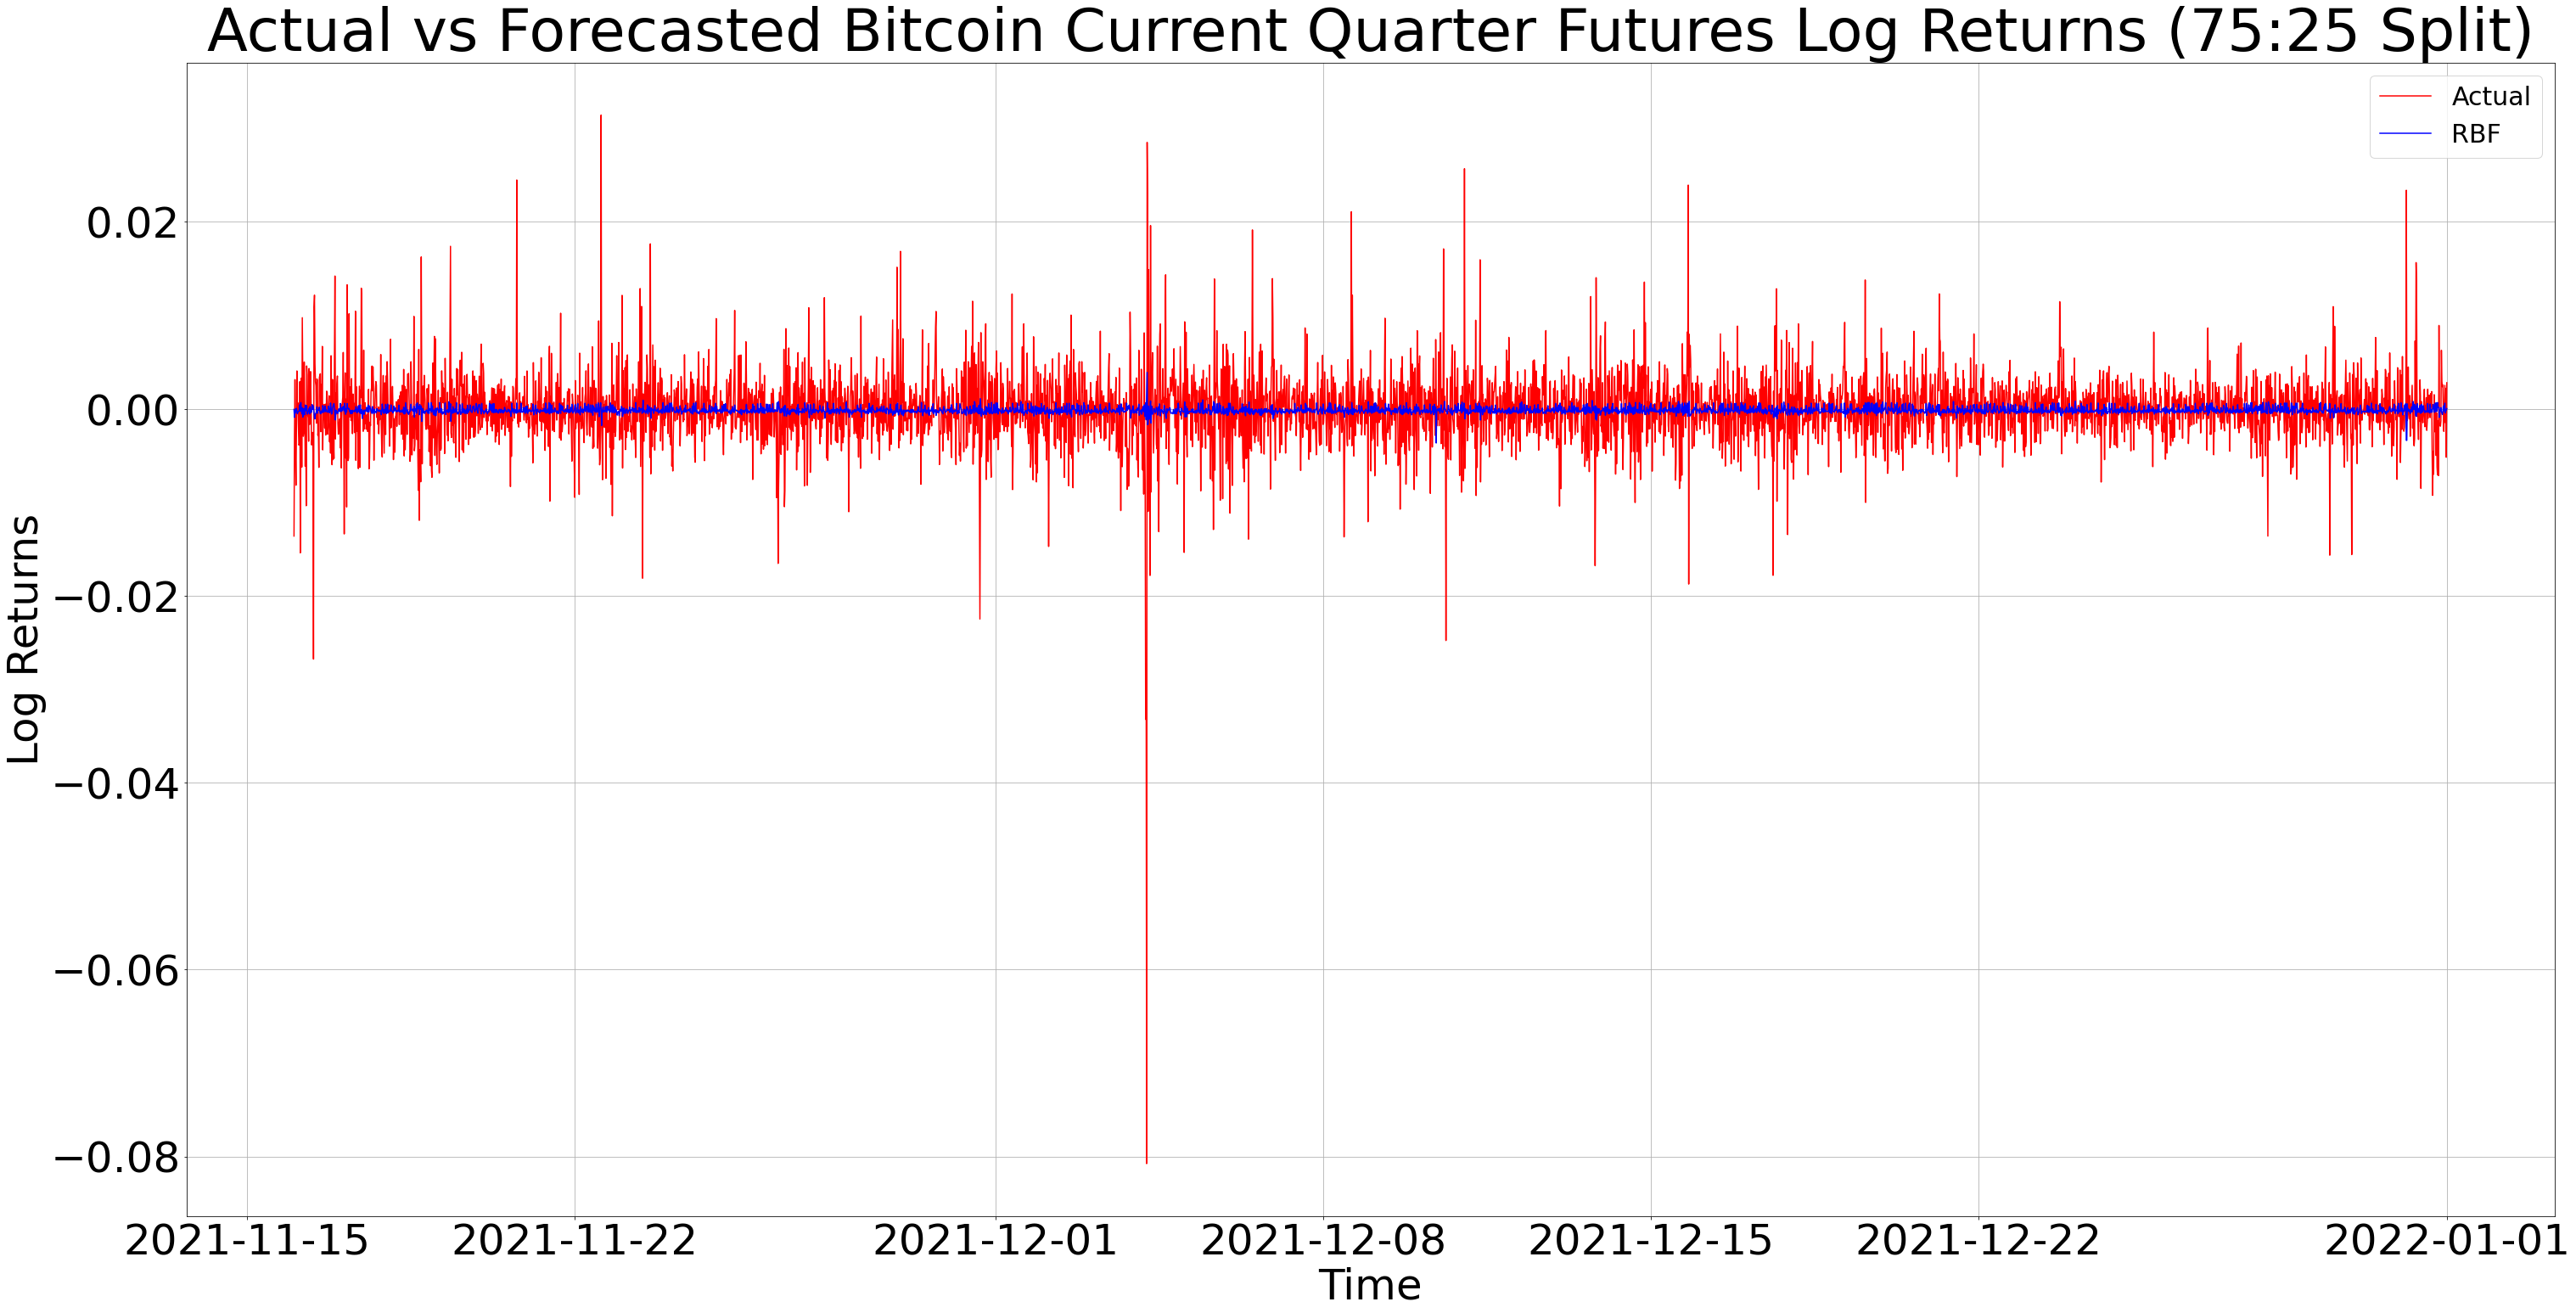

In [255]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (50,25)

ax.plot(test['time'], test['returns'], color='red', label = 'Actual')
ax.plot(test['time'], rbf_pred_2, color='blue', label = 'RBF')

plt.legend(loc="upper right", prop={'size': 30})
plt.grid(True)
#ax.set_ylim(-0.1,0.1)
ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (75:25 Split)', fontsize=70)

plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/SVR_rbf_multi_75.pdf')
plt.show()

In [256]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

rbf_mse = round(mse(np.array(test['returns']), rbf_pred_2), ndigits=10)
rbf_rmse = round(rmse(np.array(test['returns']), rbf_pred_2), ndigits=10)
rbf_mae = round(meanabs(np.array(test['returns']), rbf_pred_2), ndigits=10)

print("RBF MSE:    ", rbf_mse)
print("RBF RMSE:   ", rbf_rmse)
print("RBF MAE:    ", rbf_mae)

RBF MSE:     1.59163e-05
RBF RMSE:    0.0039895262
RBF MAE:     0.0026490803


# RBF Mixed AR (95:5)

In [257]:
train_size = int(0.95 * len(main))
train = main[:train_size]
test = main[train_size:]

X = list()
for lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol in zip(train['lag_returns_1'], train['lag_nqf_returns'], train['lag_spot_returns'], train['lag_change_cqf_vol']):
    X.append( [ lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol ] )

In [258]:
rbf_svr_model_2 = SVR(
    kernel = 'rbf', 
    C = C_rbf_2, 
    epsilon = epsilon_rbf_2, 
    gamma = gamma_rbf_2
)
rbf_svr_model_2.fit(X, train['returns'])

SVR(C=1, epsilon=0.001, gamma='auto')

In [259]:
Xtest = list()
for lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol in zip(test['lag_returns_1'], test['lag_nqf_returns'], test['lag_spot_returns'], test['lag_change_cqf_vol']):
    Xtest.append( [ lag_returns_1, lag_nqf_returns, lag_spot_returns, lag_change_cqf_vol ] )

rbf_pred_2 = rbf_svr_model_2.predict(Xtest)

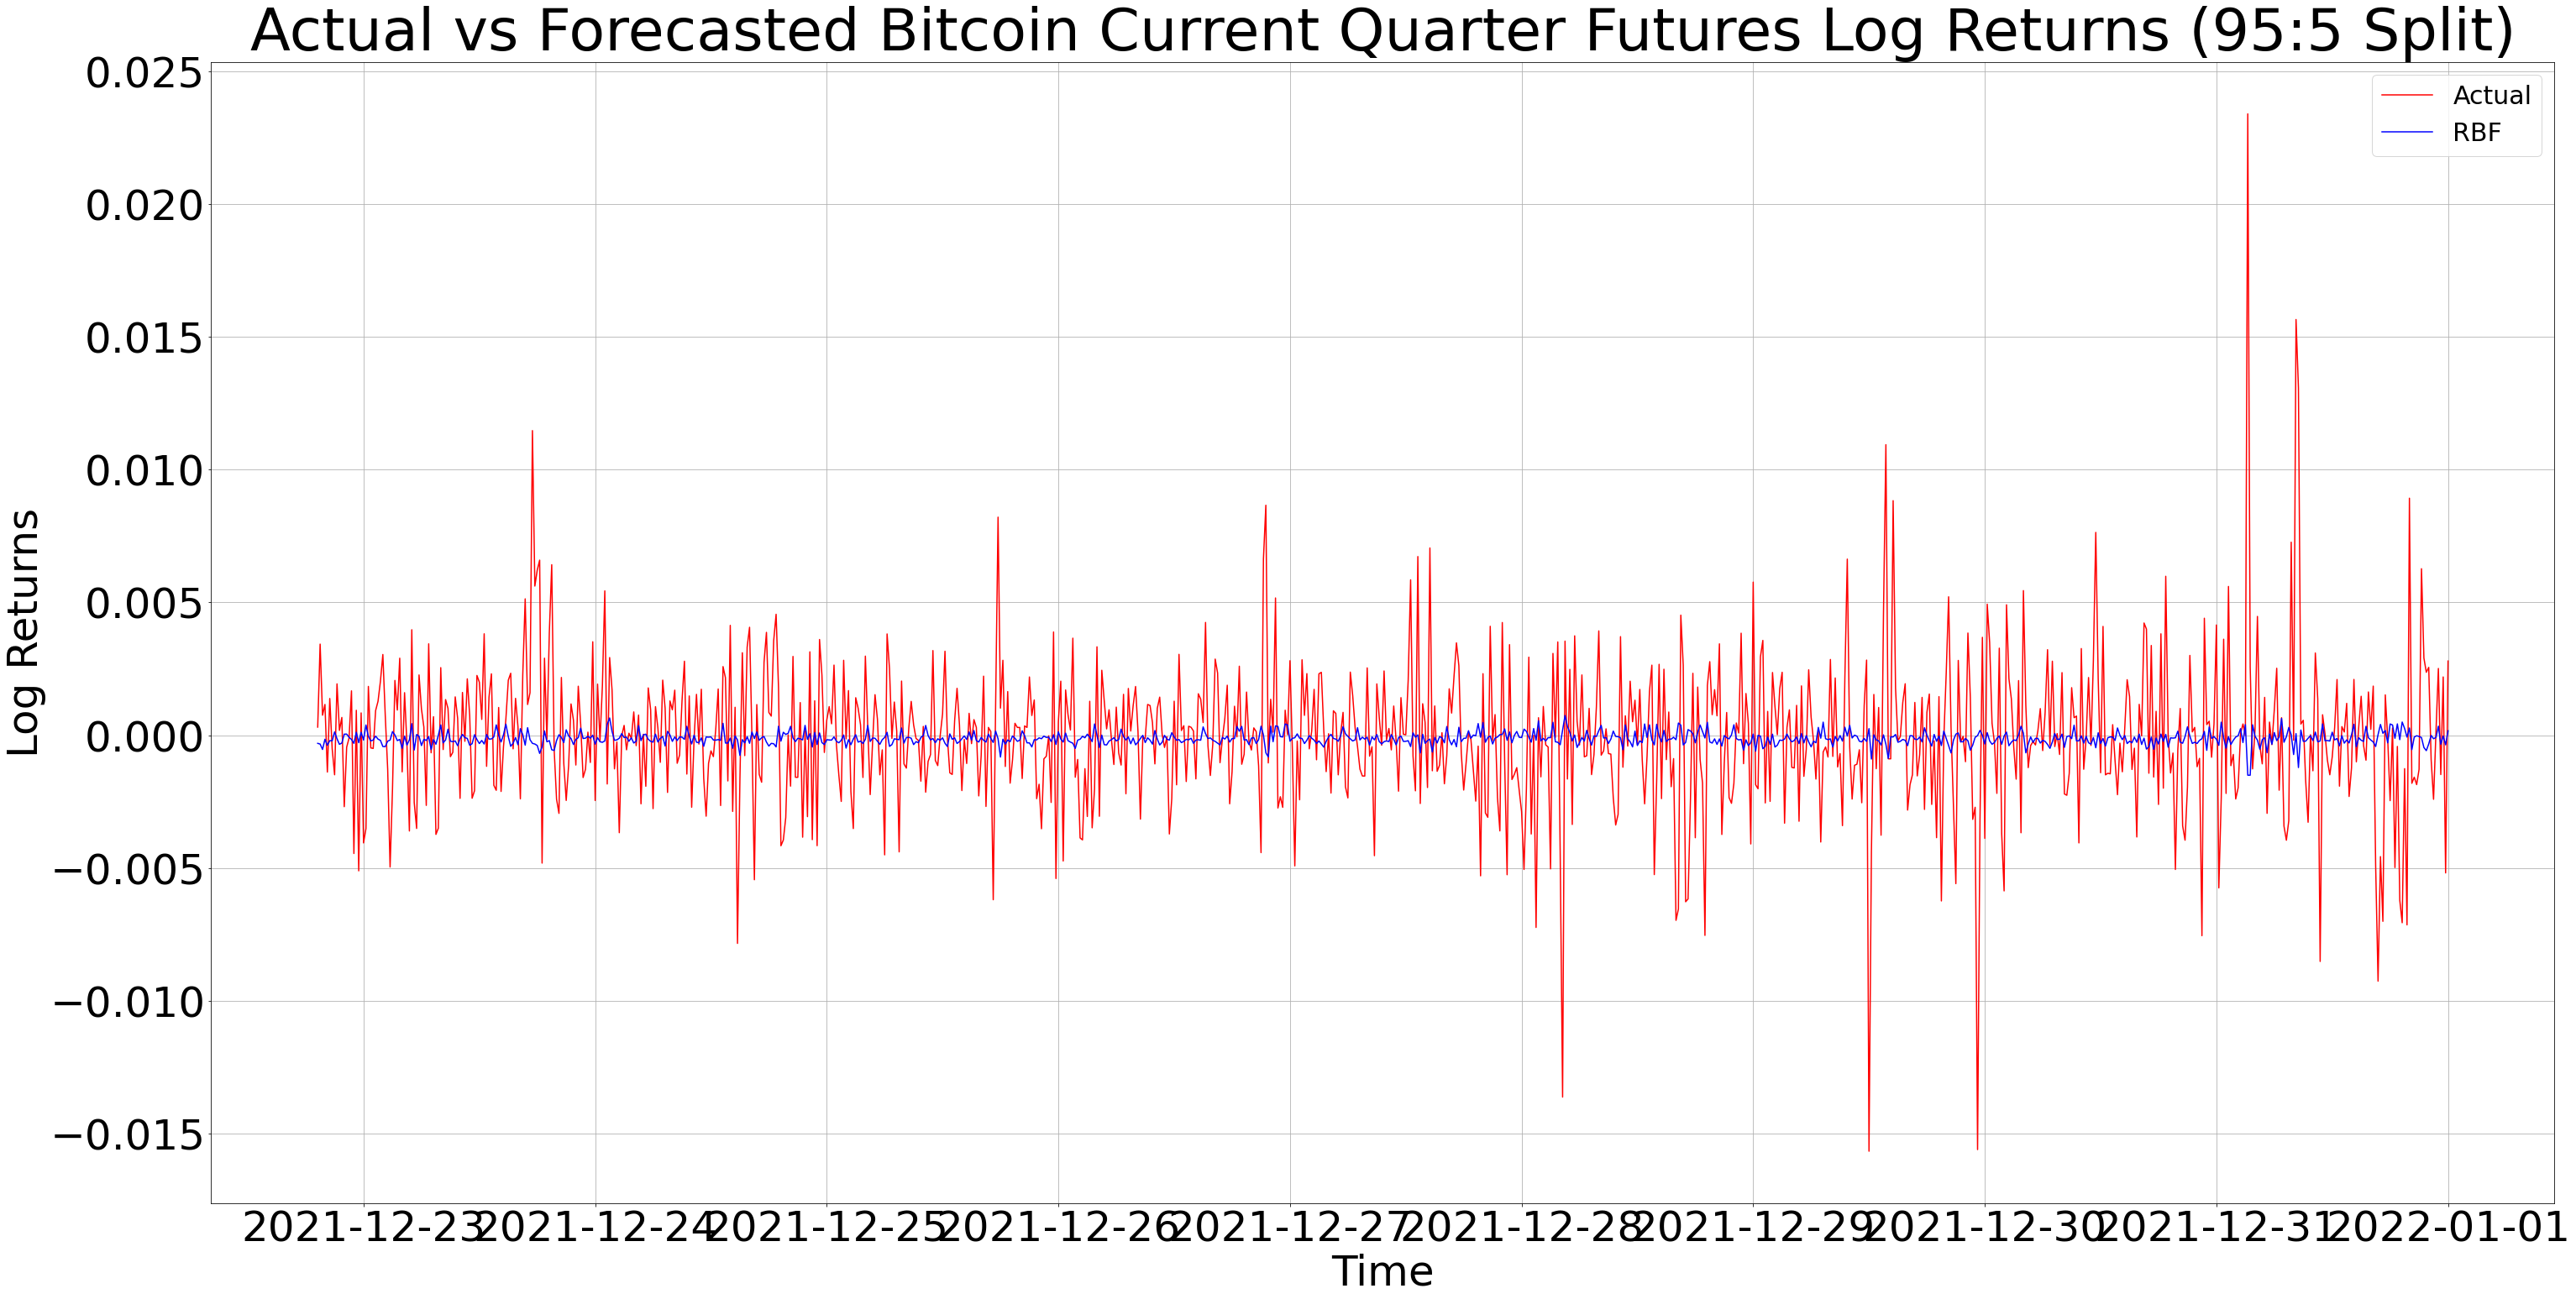

In [260]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (50,25)

ax.plot(test['time'], test['returns'], color='red', label = 'Actual')
ax.plot(test['time'], rbf_pred_2, color='blue', label = 'RBF')

plt.legend(loc="upper right", prop={'size': 30})
plt.grid(True)
ax.set_xlabel('Time', fontsize=50)
ax.set_ylabel('Log Returns', fontsize=50)
ax.tick_params(axis='both', which='major', labelsize=50)
plt.title('Actual vs Forecasted Bitcoin Current Quarter Futures Log Returns (95:5 Split)', fontsize=70)

plt.savefig('/Users/robinvandenberg/Desktop/Desktop – Robin’s MacBook Pro/Thesis/Scripts/Figures/SVR_rbf_multi_95.pdf')
plt.show()

In [261]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

rbf_mse = round(mse(np.array(test['returns']), rbf_pred_2), ndigits=10)
rbf_rmse = round(rmse(np.array(test['returns']), rbf_pred_2), ndigits=10)
rbf_mae = round(meanabs(np.array(test['returns']), rbf_pred_2), ndigits=10)

print("RBF MSE:    ", rbf_mse)
print("RBF RMSE:   ", rbf_rmse)
print("RBF MAE:    ", rbf_mae)

RBF MSE:     8.6619e-06
RBF RMSE:    0.0029431156
RBF MAE:     0.0020451229
